In [36]:
#import 
import pandas as pd 
import numpy as np 
import seaborn as sns 
from requests import get
import fmpclient
from collections import defaultdict
import matplotlib.pyplot as plt 

In [37]:
api = fmpclient.FMPClient()

In [38]:
def url_import(stock_list, info_type,params = {'datatype': 'json'}): 
    
    
    #dict_info = dict_maker(stock_list)
    dict_info = defaultdict(list)
    err_list = []
    url_list = ['''https://fmpcloud.io/api/v3/{info_type}/{stock}?apikey=cb3b0c371586d9ce915d359479fe1c81'''
                .format(info_type=info_type, stock = stock) 
    for stock in stock_list]

    print(url_list[0])
    for url, stock in zip(url_list,stock_list):
        try:
            #import financial ratios
            financial = api.requester.GET(url, params)
           
        
            for period_dict in financial: 

                for key, value in period_dict.items():
                    

                   # if key == 'date': 
                    #    dict_info[stock]['date'].append(value)
                    
                    dict_info[key].append(value)
        
        except: 
            err_list.append(stock)
            pass 
        
        
    
            
    return dict_info, err_list 

In [39]:
def url_import_latest(stock_list, info_type,params = {'datatype': 'json'}): 
    
    
    #dict_info = dict_maker(stock_list)
    dict_info = defaultdict(list)
    err_list = []
    url_list = ['''https://fmpcloud.io/api/v3/{info_type}/{stock}?apikey=cb3b0c371586d9ce915d359479fe1c81'''
                .format(info_type=info_type, stock = stock) 
    for stock in stock_list]

    print(url_list[0])
    for url, stock in zip(url_list,stock_list):
        try:
            #import financial ratios
            financial = api.requester.GET(url, params)
           
        

            for key, value in financial[0].items():
                
                    

                   # if key == 'date': 
                    #    dict_info[stock]['date'].append(value)
                    
                dict_info[key].append(value)
        
        except: 
            err_list.append(stock)
            pass 
        
        
    
            
    return dict_info, err_list

In [40]:
def intrinsic_cash(cf_ests, grs,drs, lgr,shares,n):
    iv_dict = defaultdict(list)
    for cf_est in cf_ests: 
        for gr in grs: 
            iv_dict['{},{}%'.format(cf_est/1000,gr*100)] = []
            for dr in drs: 
                
                fcfn = [ cf_est * (1 + gr)**i for i in range(1,n+1)]
                dfn = [(1+dr)**i for i in range(1,n+1)]
                dcf = sum([fcf/df for fcf, df in zip(fcfn,dfn)])
                dpcf = ((cf_est * (1 + gr)**(n+1) * (1 + lgr)) / (dr - lgr)) * (1 / (1 + dr)**(n+1))
                iv = (dcf + dpcf) / shares
                iv_dict['{},{}%'.format(cf_est/1000,gr*100)].append(iv)
    return iv_dict

In [41]:
def intrn_avg(dict_iv): 
    dict_final = defaultdict(float)
    for key, value in dict_iv.items():
        dict_final[key] = np.mean(value)
    return dict_final
        

In [42]:
def intrinsic_bk(avg_div_yr, pbvPersh_est, gr,dr,n): 
    fbv = pbvPersh_est * (1 + gr)**n 
    div = avg_div_yr * ((1 - (1 / (1 + dr)**n)) / dr)
    return div + (fbv / (1 + dr)**n)

In [43]:
def annual_growth(f,i,n): 
    return ((f/i)**(1/n) - 1)

In [44]:
def price_ratios(df, price): 
    df['pe'] = price / df.eps 
    df['ps'] = price  / (df.revenue / df .shares)
    df['pb'] = price / df.bv
    df['pfcf'] = price / (df['freeCashFlow'] / df['shares'])
    df['pocf'] = price / (df['operatingCashFlow'] / df['shares'])
    return df

In [956]:
def metrics(df): 
    df['de'] =df['totalDebt'] /df['totalStockholdersEquity']
    df['curr'] = df['totalCurrentAssets'] / df['totalCurrentLiabilities']
    df['debtRatio'] = df['totalDebt'] / df['totalAssets']
    df['ocfRatio'] = df['operatingCashFlow'] / df['revenue']
    df['fcfRatio'] = df['freeCashFlow'] / df['revenue']
    df['roe'] = df['netIncome'] / df['totalStockholdersEquity']
    df['roi'] = df['netIncome'] / df['totalAssets']
    df['rof'] = df['freeCashFlow'] / df['totalStockholdersEquity']
    df['rocf'] = df['operatingCashFlow'] / df['totalStockholdersEquity']
    df['intCov'] = df['operatingIncome'] / df['interestExpense']
    df['bv'] = df['totalStockholdersEquity'] / df['shares']
    df['div']= np.abs(df['dividendsPaid'])/df['shares']
    df['fcf'] =df['freeCashFlow'] /df['shares']
    df['ocf'] = df['operatingCashFlow']/ df['shares']
    df['invTurnOver'] = np.abs(df['costOfRevenue']) / df['inventory']
    df['recTurnOver'] = df['revenue'] / df['netReceivables']
    df['payTurnOver'] = np.abs(df['costOfRevenue']) / df['accountPayables']
    df['ownerCash'] = df['freeCashFlow']  / df['revenue']
    df['gcf'] = np.abs(df['netCashUsedForInvestingActivites']) / df['operatingCashFlow']
    return df 
    

In [45]:
import re

# AMC 

In [46]:
dict_amc_cash,errs_amc = url_import(['AMC'], 'cash-flow-statement')
dict_amc_balance,errs_amc = url_import(['AMC'], 'balance-sheet-statement')
dict_amc_income,errs_amc = url_import(['AMC'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/AMC?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/AMC?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/AMC?apikey=cb3b0c371586d9ce915d359479fe1c81


In [47]:
df_amc_cash = pd.DataFrame(dict_amc_cash)
df_amc_bal = pd.DataFrame(dict_amc_balance)
df_amc_income = pd.DataFrame(dict_amc_income)

In [48]:
df_amc_bal.date = df_amc_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_amc_cash.date = df_amc_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_amc_income.date = df_amc_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [49]:
df_amc_bal.set_index(['date'], inplace = True)
df_amc_cash.set_index(['date'], inplace = True)
df_amc_income.set_index(['date'], inplace = True)

In [50]:
df_amc = pd.concat([df_amc_income,df_amc_bal,df_amc_cash],axis = 1)

In [51]:
df_amc.drop(['symbol','period'],axis = 1, inplace =True)

In [52]:
df_amc['shares'] = 104.2E06

In [53]:
df_amc = df_amc/1000

In [54]:
df_amc[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_amc[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [55]:
df_amc = df_amc.sort_index()

In [56]:
df_amc_main = df_amc.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [57]:
df_amc_main['netIncome'] = df_amc_income['netIncome'] / 1000

# princi 1
# de

In [58]:
df_amc['de'] = df_amc.totalDebt/df_amc.totalStockholdersEquity

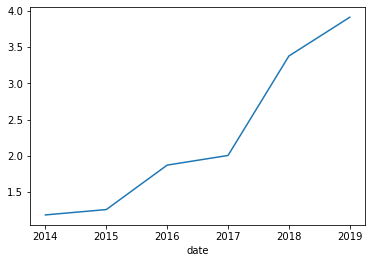

In [59]:
df_amc.de.plot()

In [60]:
df_amc.de.mean()

2.268527475218947

# de --> susck --> rf1

# curr

In [61]:
df_amc_main['curr'] = df_amc.totalCurrentAssets / df_amc.totalCurrentLiabilities

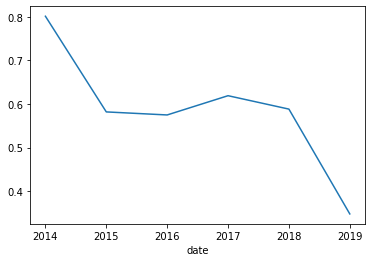

In [62]:
df_amc_main.curr.plot()

In [65]:
df_amc_main.curr.mean()

0.5855305175985501

# curr --> fail 
# roe

In [ ]:
df_amc['roe'] = df_amc_main.netIncome / df_amc.totalStockholdersEquity

In [ ]:
df_amc.roe.plot()

In [ ]:
df_amc.roe.mean()

In [ ]:
df_amc.eps.plot()

In [ ]:
df_amc.eps

In [ ]:
df_amc.totalStockholdersEquity.plot()

# rf 4 --> amc = fail

# AMCX 

In [ ]:
dict_amcx_cash,errs_amcx = url_import(['AMCX'], 'cash-flow-statement')
dict_amcx_balance,errs_amcx = url_import(['AMCX'], 'balance-sheet-statement')
dict_amcx_income,errs_amcx = url_import(['AMCX'], 'income-statement')

In [ ]:
df_amcx_cash = pd.DataFrame(dict_amcx_cash)
df_amcx_bal = pd.DataFrame(dict_amcx_balance)
df_amcx_income = pd.DataFrame(dict_amcx_income)

In [ ]:
df_amcx_bal.date = df_amcx_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_amcx_cash.date = df_amcx_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_amcx_income.date = df_amcx_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [ ]:
df_amcx_bal.set_index(['date'], inplace = True)
df_amcx_cash.set_index(['date'], inplace = True)
df_amcx_income.set_index(['date'], inplace = True)

In [ ]:
df_amcx = pd.concat([df_amcx_income,df_amcx_bal,df_amcx_cash],axis = 1)

In [ ]:
df_amcx.drop(['symbol','period'],axis = 1, inplace =True)

In [ ]:
df_amcx['shares'] = 55.56E06

In [ ]:
df_amcx = df_amcx/1000

In [ ]:
df_amcx[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_amcx[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [ ]:
df_amcx = df_amcx.sort_index()

In [ ]:
df_amcx_main = df_amcx.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [ ]:
df_amcx_main['netIncome'] = df_amcx_income['netIncome'] / 1000

# PRINCIPLE 1
# DE

In [ ]:
df_amcx['de'] = df_amcx.totalDebt/df_amcx.totalStockholdersEquity

In [ ]:
df_amcx.de.plot()

In [ ]:
df_amcx.de

In [ ]:
df_amcx.totalStockholdersEquity

In [ ]:
(df_amcx.totalCurrentAssets / df_amcx.totalCurrentLiabilities).mean()

# roe

In [ ]:
df_amcx.roe = df_amcx_main.netIncome / df_amcx.totalStockholdersEquity

In [ ]:
df_amcx.roe.values[4:].mean()

In [ ]:
df_amcx.roe.plot()

In [ ]:
df_amcx.freeCashFlow.plot()

In [ ]:
df_amcx.totalLiabilities.plot()

In [ ]:
df_amcx.totalAssets.plot()

In [ ]:
df_amcx.eps

# pass so far 
# grs 

In [ ]:
df_amcx[['operatingIncome','interestExpense']]

In [ ]:
annual_growth(625277.0,326516.0,8 ),  annual_growth(157798,95870.0,8)

In [ ]:
df_amcx[['totalAssets','totalLiabilities']]

In [ ]:
annual_growth(5596686.0,2183934.0,8), annual_growth(4930905.0,3220929.0,8)

In [ ]:
df_amcx[['operatingCashFlow','netCashUsedProvidedByFinancingActivities']]

# grs --> veryyy good 
# principle 1 --> all pass 

# nahhh

In [ ]:
df_amcx['bv'] = df_amcx.totalStockholdersEquity /df_amcx.shares

In [ ]:
df_amcx.bv

# GM 


In [ ]:
dict_gm_cash,errs_gm = url_import(['GM'], 'cash-flow-statement')
dict_gm_balance,errs_gm = url_import(['GM'], 'balance-sheet-statement')
dict_gm_income,errs_gm = url_import(['GM'], 'income-statement')

In [ ]:
df_gm_cash = pd.DataFrame(dict_gm_cash)
df_gm_bal = pd.DataFrame(dict_gm_balance)
df_gm_income = pd.DataFrame(dict_gm_income)

In [ ]:
df_gm_bal.date = df_gm_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_gm_cash.date = df_gm_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_gm_income.date = df_gm_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [ ]:
df_gm_bal.set_index(['date'], inplace = True)
df_gm_cash.set_index(['date'], inplace = True)
df_gm_income.set_index(['date'], inplace = True)

In [ ]:
df_gm = pd.concat([df_gm_income,df_gm_bal,df_gm_cash],axis = 1)

In [ ]:
df_gm.drop(['symbol','period'],axis = 1, inplace =True)

In [ ]:
df_gm['shares'] = 1.423E09

In [ ]:
df_gm = df_gm/1000

In [ ]:
df_gm[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_gm[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [ ]:
df_gm = df_gm.sort_index()

In [ ]:
df_gm_main = df_gm.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [ ]:
df_gm_main['netIncome'] = df_gm_income['netIncome'] / 1000

# principle 1
# de 

In [ ]:
df_gm['de'] = df_gm.totalDebt / df_gm.totalStockholdersEquity

In [ ]:
df_gm.de.plot()

In [ ]:
df_gm.de

In [ ]:
df_gm.de.mean()

# de --> pass 
# current 

In [ ]:
df_gm['curr'] = df_gm.totalCurrentAssets / df_gm.totalCurrentLiabilities

In [ ]:
df_gm.curr.plot()

In [ ]:
df_gm.curr.mean()

In [ ]:
df_gm[['totalCurrentAssets','totalCurrentLiabilities']]

In [ ]:
annual_growth(74992000.0,60247000.0,8), annual_growth(84905000.0,48932000.0,8)

# curr --> not so good ; rf 1 

# roe

In [ ]:
df_gm['roe'] = df_gm_main.netIncome / df_gm.totalStockholdersEquity

In [ ]:
df_gm.roe.mean()

In [ ]:
df_gm.roe.plot()

# roe --> too good 
# grs 

In [ ]:
df_gm['intCov'] = df_gm.operatingIncome/ df_gm.interestExpense

In [ ]:
df_gm[['interestExpense','operatingIncome']]

In [ ]:
annual_growth(5481000.0,5131000.0,8), annual_growth(4423000.0,744000.0,8)

In [ ]:
df_gm.netCashUsedForInvestingActivites.plot()

In [ ]:
df_gm.researchAndDevelopmentExpenses.plot()

In [ ]:
df_gm['bv'] = df_gm.totalStockholdersEquity / df_gm.shares

In [ ]:
df_gm.bv.mean()

In [ ]:
df_gm['div'] = np.abs(df_gm.dividendsPaid) / df_gm.shares

In [ ]:
df_gm[['bv','eps','div','totalAssets','totalLiabilities']].plot(subplots = True, figsize = (12,12), 
                                                               layout = (3,-1))
plt.show()

In [ ]:
df_gm[['freeCashFlow','netCashUsedProvidedByFinancingActivities','netCashUsedForInvestingActivites','netCashProvidedByOperatingActivites']] \
.plot(subplots = True, layout = (3,-1), figsize = (11,11))

In [ ]:
df_gm.netCashUsedForInvestingActivites

# pricing 

In [ ]:
df_gm['pe'] = 22 / df_gm.eps 
df_gm['ps'] = 22/ (df_gm['revenue'] / df_gm.shares)
df_gm['pb'] = 22 / df_gm.bv

In [ ]:
df_gm[['pe','ps','pb','div']]

# all checkk 
# valuation 


In [ ]:
df_gm.freeCashFlow

In [ ]:
#cf 
cf_est = [df_gm.freeCashFlow.mean()]
grs = [0.1,0.18] 
drs = [0.15,0.2,0.25]
lgr =0.03 

In [ ]:
dict_ivs_gm = intrinsic_cash(cf_est,grs,drs,lgr,df_gm.shares.values[0],8)

In [ ]:
intrn_avg(dict_ivs_gm)

In [ ]:
annual_growth(df_gm.bv.values[-1],df_gm.bv.values[0],8)

In [ ]:
intrinsic_bk(1.6, 29,0.02,0.15,8)

# broadcast
# T 

In [ ]:
dict_t_cash,errs_t = url_import(['T'], 'cash-flow-statement')
dict_t_balance,errs_t = url_import(['T'], 'balance-sheet-statement')
dict_t_income,errs_t = url_import(['T'], 'income-statement')

In [ ]:
df_t_cash = pd.DataFrame(dict_t_cash)
df_t_bal = pd.DataFrame(dict_t_balance)
df_t_income = pd.DataFrame(dict_t_income)

In [ ]:
df_t_bal.date = df_t_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_t_cash.date = df_t_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_t_income.date = df_t_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [ ]:
df_t_bal.set_index(['date'], inplace = True)
df_t_cash.set_index(['date'], inplace = True)
df_t_income.set_index(['date'], inplace = True)

In [ ]:
df_t_cash.drop('netIncome',axis = 1,inplace = True)

In [ ]:
df_t = pd.concat([df_t_income,df_t_bal,df_t_cash],axis = 1)

In [ ]:
df_t.drop(['symbol','period'],axis = 1, inplace =True)

In [ ]:
df_t['shares'] = 7.173E09

In [ ]:
df_t = df_t/1000

In [ ]:
df_t[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_t[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [ ]:
df_t = df_t.sort_index()

In [ ]:
df_t_main = df_t.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

# principle 1: 
# De

In [ ]:
df_t['de'] = df_t.totalDebt / df_t.totalStockholdersEquity

In [ ]:
df_t.de.mean()

In [ ]:
df_t.de.plot()

In [ ]:
# current ratio 
df_t['curr'] = df_t.totalCurrentAssets / df_t.totalCurrentLiabilities

In [ ]:
df_t.curr.plot()

In [ ]:
df_t.curr

In [ ]:
df_t['intCov'] =df_t.operatingIncome / df_t.interestExpense

In [ ]:
df_t.intCov

In [ ]:
df_t['roe'] = df_t.netIncome / df_t.totalStockholdersEquity

In [ ]:
df_t.roe.plot()

In [ ]:
df_t.roe.median()

In [ ]:
#grs 
df_t[['totalAssets','totalLiabilities','operatingCashFlow']]

In [ ]:
annual_growth(48668000.0,34648000.0,9)

# principle 3 
# BV 

In [ ]:
df_t['bv'] = df_t.totalStockholdersEquity / df_t.shares 
df_t['div'] = np.abs(df_t['dividendsPaid']) / df_t.shares

In [ ]:
annual_growth(28.151959,14.749338,9)

In [ ]:
df_t.bv.pct_change()

In [ ]:
annual_growth(2.075561,1.418096,9)

In [ ]:
df_t['div']

In [ ]:
df_t[['bv', 'div','eps','totalAssets','totalLiabilities']].plot(subplots = True, figsize = (11,11),
                                                               layout = (3,-1))

In [ ]:
df_t.eps

In [ ]:
df_t['ocf'] = df_t.operatingCashFlow / df_t.shares 
df_t['fcf'] = df_t['freeCashFlow'] / df_t.shares

In [ ]:
df_t[['operatingCashFlow','netCashUsedProvidedByFinancingActivities','netCashUsedForInvestingActivites','freeCashFlow']]\
.plot(subplots = True,layout=(3,-1),figsize = (11,11))

# principle 4: 
# prices 

In [ ]:
df_t['pe'] = 30/ df_t.eps
df_t['ps'] = 30 / (df_t.revenue /df_t.shares)
df_t['pb'] = 30 / df_t.bv 
df_t['pfcf'] = 30 / df_t.fcf

In [ ]:
df_t[['pe','ps','pb','pfcf']]

In [ ]:
df_t['div'] / 30

In [ ]:
annual_growth(29233000.0,14538000.0,9)

In [ ]:
df_t.freeCashFlow

In [ ]:
cf_ests = [df_t.freeCashFlow.median(),df_t.freeCashFlow.values[-1]]
grs = [0.08, 0.11]
drs = [0.15,0.2,0.25] 

In [ ]:
dict_ivs_t = intrinsic_cash(cf_ests,grs,drs,lgr,df_t.shares.values[-1],9)

In [ ]:
intrn_avg(dict_ivs_t)

In [ ]:
df_t.bv.mean()

In [ ]:
intrinsic_bk(1.5,17.5, 0.07,0.1,9 )

# bbgi


In [ ]:
dict_bb_cash,errs_bb = url_import(['BBGI'], 'cash-flow-statement')
dict_bb_balance,errs_bb = url_import(['BBGI'], 'balance-sheet-statement')
dict_bb_income,errs_bb = url_import(['BBGI'], 'income-statement')

In [ ]:
df_bb_cash = pd.DataFrame(dict_bb_cash)
df_bb_bal = pd.DataFrame(dict_bb_balance)
df_bb_income = pd.DataFrame(dict_bb_income)

In [ ]:
df_bb_bal.date = df_bb_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_bb_cash.date = df_bb_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_bb_income.date = df_bb_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [ ]:
df_bb_bal.set_index(['date'], inplace = True)
df_bb_cash.set_index(['date'], inplace = True)
df_bb_income.set_index(['date'], inplace = True)

In [ ]:
df_bb = pd.concat([df_bb_income,df_bb_bal,df_bb_cash],axis = 1)

In [ ]:
df_bb.drop(['symbol','period'],axis = 1, inplace =True)

In [ ]:
df_bb['shares'] = 27.98E06

In [ ]:
df_bb = df_bb/1000

In [ ]:
df_bb[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_bb[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [ ]:
df_bb = df_bb.sort_index()

In [ ]:
df_bb_main = df_bb.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [ ]:
df_bb_main['netIncome'] = df_bb_income['netIncome'] / 1000

# 1
# DE

In [ ]:
df_bb['de'] =df_bb['totalDebt']/ df_bb.totalStockholdersEquity

In [ ]:
df_bb.de.mean()

In [ ]:
df_bb.de.plot()

In [ ]:
# roe 
df_bb['curr'] = df_bb.totalCurrentAssets / df_bb.totalCurrentLiabilities

In [ ]:
df_bb.curr.mean()

In [ ]:
df_bb.curr.plot()

In [ ]:
df_bb['intCov'] = df_bb.operatingIncome / df_bb.interestExpense

In [ ]:
df_bb[['intCov','operatingIncome','shortTermDebt','interestExpense','totalAssets','totalLiabilities']]\
.apply(lambda x: annual_growth(x[-1],x[0],9))

In [ ]:

annual_growth(18032.669,7357.943,9)

In [ ]:
#ROE 
df_bb['roe'] = df_bb_main.netIncome / df_bb.totalStockholdersEquity

In [ ]:
df_bb.roe

In [ ]:
df_bb.roe.plot()

# pass 
# buss
# roe somewhat worrisome 

In [ ]:
df_bb.shares

In [ ]:
df_bb.totalDebt/df_bb.totalAssets

# principle 1,2 --> good 
# principle 3

In [ ]:
df_bb['bv'] = df_bb.totalStockholdersEquity / df_bb.shares
df_bb['divv'] = np.abs(df_bb['dividendsPaid']) / df_bb.shares  

In [ ]:
df_bb.divv

In [ ]:
df_bb[['divv','bv']].agg(['mean', lambda x: annual_growth(x[-1],x[1],8)])

In [ ]:
df_bb[['bv','divv','eps','totalAssets','totalLiabilities']].plot(subplots = True, figsize = (11,11),
                                                                layout = (3,-1))

In [ ]:
df_bb['fcf'] = df_bb.freeCashFlow  / df_bb.shares
df_bb['ocf'] = df_bb.operatingCashFlow / df_bb.shares 

In [ ]:
df_bb[['fcf','ocf']]

In [ ]:
df_bb = price_ratios(df_bb,2.4)

In [ ]:
df_bb[['pe','ps','pb']].agg(['mean',lambda x: annual_growth(x[-1],x[0],9)])

In [ ]:
annual_growth

In [ ]:
df_bb[['freeCashFlow']].apply(lambda x: annual_growth(x[-1],x[1],9))

In [ ]:
# valuation 
cf_ests = [df_bb.freeCashFlow.median()]
grs = [0.03,0.05]
lgr = 0.03 


In [ ]:
intrn_avg(intrinsic_cash(cf_ests, grs, drs, lgr, df_bb.shares.values[0],9 ))

In [35]:
intrinsic_bk(0.13,7,0.1,0.15,9)

5.312237196322275

# safe AF 
# buy 2.5-3k

# Retail 
# dbi

In [93]:
dict_dbi_cash,errs_dbi = url_import(['DBI'], 'cash-flow-statement')
dict_dbi_balance,errs_dbi = url_import(['DBI'], 'balance-sheet-statement')
dict_dbi_income,errs_dbi = url_import(['DBI'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/DBI?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/DBI?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/DBI?apikey=cb3b0c371586d9ce915d359479fe1c81


In [118]:
df_dbi_cash = pd.DataFrame(dict_dbi_cash)
df_dbi_bal = pd.DataFrame(dict_dbi_balance)
df_dbi_income = pd.DataFrame(dict_dbi_income)

In [119]:
df_dbi_bal.date = df_dbi_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_dbi_cash.date = df_dbi_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_dbi_income.date = df_dbi_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [120]:
df_dbi_bal.set_index(['date'], inplace = True)
df_dbi_cash.set_index(['date'], inplace = True)
df_dbi_income.set_index(['date'], inplace = True)

In [121]:
df_dbi_cash.drop('netIncome',axis = 1, inplace = True)

In [122]:
df_dbi_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [123]:
df_dbi = pd.concat([df_dbi_income,df_dbi_bal,df_dbi_cash],axis = 1)

In [124]:
df_dbi.drop(['symbol','period'],axis = 1, inplace =True)

In [125]:
df_dbi['shares'] = 71.75E06

In [126]:
df_dbi.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [127]:
df_dbi = df_dbi/1000

In [128]:
df_dbi[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_dbi[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [129]:
df_dbi = df_dbi.sort_index()

In [130]:
df_dbi_main = df_dbi.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [131]:
df_dbi_main['netIncome'] = df_dbi_income['netIncome'] / 1000

# principle 1


In [161]:
df_dbi = metrics(df_dbi)

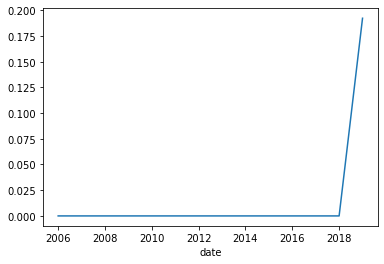

In [137]:
df_dbi.de.plot()

In [140]:
df_dbi.de

date
2006    0.000000
2007    0.000000
2008    0.000000
2009    0.000000
2010    0.000000
2011    0.000000
2012    0.000000
2013    0.000000
2014    0.000000
2015    0.000000
2016    0.000000
2017    0.000000
2018    0.000000
2019    0.192221
Name: de, dtype: float64

In [145]:
df_dbi.curr

date
2006    2.708788
2007    2.875492
2008    2.673823
2009    2.867798
2010    2.701107
2011    2.826708
2012    2.822337
2013    2.984952
2014    2.857800
2015    2.707883
2016    2.460124
2017    2.398149
2018    2.659291
2019    2.062395
Name: curr, dtype: float64

In [149]:
df_dbi.roe.median()

0.08755603126278136

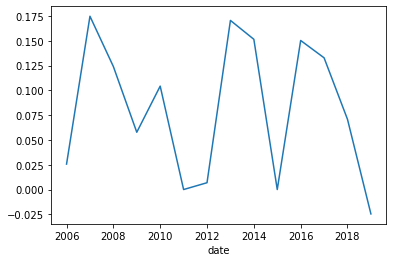

In [147]:
df_dbi.roe.plot()

In [151]:
df_dbi.roi.mean()

0.053617529085657555

In [155]:
df_dbi

,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,generalAndAdministrativeExpenses,sellingAndMarketingExpenses,otherExpenses,operatingExpenses,costAndExpenses,...,intCov,bv,div,fcf,ocf,invTurnOver,recTurnOver,payTurnOver,ownerCash,gcf
date,,,,,,,,,,,,,,,,,,,,,
2006,232559.0,-164972.0,67587.0,0.290623,0.0,0.0,0.0,0.0,-53782.0,-218754.0,...,inf,4.246913,0.000000,1.169519,1.522746,-0.761299,57.578361,-2.091191,0.360825,0.231134
2007,1279060.0,-912709.0,366351.0,0.286422,0.0,0.0,0.0,0.0,-265637.0,-1178346.0,...,-175.288274,5.220613,0.000000,0.645101,1.228822,-3.839154,274.417507,-10.163118,0.036188,1.593741
2008,1405615.0,-1035480.0,370135.0,0.263326,0.0,0.0,0.0,0.0,-288814.0,-1324294.0,...,-74.101019,6.041533,0.000000,-0.391498,0.987596,-3.951656,119.069462,-9.114740,-0.019984,1.168727
2009,1462944.0,-1083845.0,379099.0,0.259134,0.0,0.0,0.0,0.0,-336286.0,-1420131.0,...,-55.774559,6.488976,0.000000,0.207916,1.353436,-4.441842,213.537294,-11.665285,0.010197,1.072455
2010,1602605.0,-1135113.0,2737718.0,1.708292,0.0,0.0,0.0,0.0,-2367.0,-1137480.0,...,-64.986563,7.315415,0.000000,1.970355,2.292028,-4.327801,296.449316,-9.533637,0.088215,0.532298
2011,1680889.0,1145505.0,535384.0,0.318512,0.0,0.0,0.0,0.0,0.0,1145505.0,...,NaN,8.930509,0.000000,1.313087,1.964446,3.706980,135.195769,7.706158,0.056050,1.249551
2012,449537.0,-302172.0,751709.0,1.672185,0.0,0.0,0.0,0.0,-98945.0,-401117.0,...,inf,10.962885,1.377826,1.943916,2.985129,-0.903651,26.599822,-2.028762,0.310266,0.651863
2013,2257778.0,-1533058.0,3790836.0,1.679012,0.0,0.0,0.0,0.0,-481797.0,-2014855.0,...,inf,11.966258,1.800906,2.181603,3.603679,-3.893046,84.383989,-10.189072,0.069329,0.461812
2014,2368668.0,-1629381.0,3998049.0,1.687889,0.0,0.0,0.0,0.0,-497899.0,-2127280.0,...,inf,13.916990,0.471833,2.996000,4.200348,-4.096310,89.071109,-9.701642,0.090753,0.801025


In [157]:
df_dbi[['revenue','operatingIncome','totalLiabilities','netCashUsedForInvestingActivites','ocf','fcf']].agg(
    ['mean',lambda x: annual_growth(x[-1],x[0],18)])

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


,revenue,operatingIncome,totalLiabilities,netCashUsedForInvestingActivites,ocf,fcf
mean,1.886239e+06,42517.571429,916557.285714,-115620.571429,2.452825,1.464655
<lambda>,1.564679e-01,NaN,0.024737,0.143457,0.026626,0.015142


In [159]:
df_dbi.costOfRevenue

date
2006    -164972.0
2007    -912709.0
2008   -1035480.0
2009   -1083845.0
2010   -1135113.0
2011    1145505.0
2012    -302172.0
2013   -1533058.0
2014   -1629381.0
2015    1625834.0
2016   -1851879.0
2017   -1939611.0
2018   -2010418.0
2019   -2239229.0
Name: costOfRevenue, dtype: float64

In [162]:
df_dbi['invTurnOver']

date
2006    0.761299
2007    3.839154
2008    3.951656
2009    4.441842
2010    4.327801
2011    3.706980
2012    0.903651
2013    3.893046
2014    4.096310
2015    3.606265
2016    3.824332
2017    3.879261
2018    4.005591
2019    3.469967
Name: invTurnOver, dtype: float64

In [163]:
df_dbi['recTurnOver']

date
2006     57.578361
2007    274.417507
2008    119.069462
2009    213.537294
2010    296.449316
2011    135.195769
2012     26.599822
2013     84.383989
2014     89.071109
2015     96.412459
2016    169.738162
2017    146.913958
2018    159.696213
2019     46.228227
Name: recTurnOver, dtype: float64

In [165]:
df_dbi.eps

date
2006    0.28
2007    1.49
2008    1.22
2009    0.61
2010    1.24
2011    0.00
2012   -0.41
2013    3.27
2014    1.67
2015    0.00
2016    1.55
2017    1.53
2018    0.84
2019   -0.26
Name: eps, dtype: float64

# prin 1, 2 goodd
# bv

In [171]:
df_dbi[['div','bv']].apply(lambda x: annual_growth(x[-1],x[8],18))

div    0.048786
bv    -0.010061
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125d55d90>,
      dtype=object)

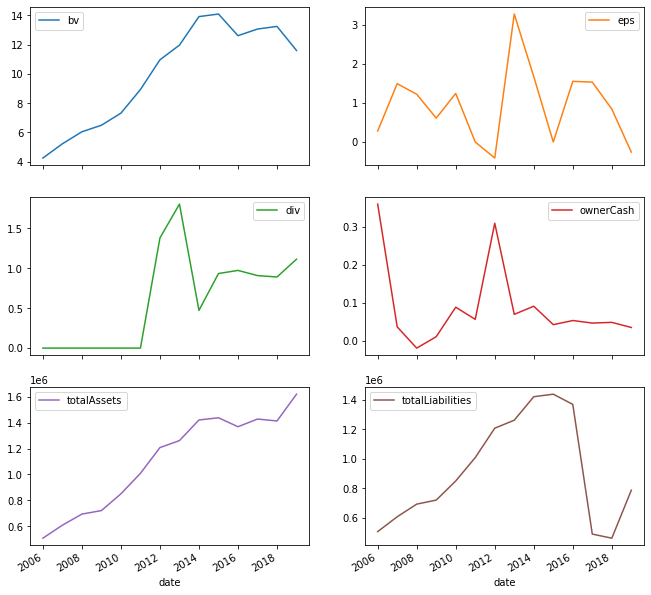

In [172]:
df_dbi[['bv','eps','div','ownerCash','totalAssets','totalLiabilities']].plot(subplots = True,
                                                                            figsize = (11,11),
                                                                            layout = (3,-1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1257b0bd0>,
      dtype=object)

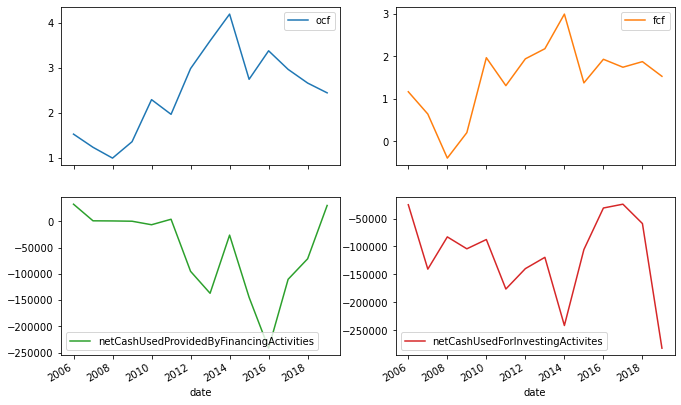

In [175]:
df_dbi[['ocf','fcf','netCashUsedProvidedByFinancingActivities','netCashUsedForInvestingActivites']]\
.plot(figsize = (11,11),subplots = True,layout = (3,-1))

In [177]:
df_dbi = price_ratios(df_dbi,6.38)

In [178]:
df_dbi[['pe','ps','pb']]

,pe,ps,pb
date,,,
2006,22.785714,1.968382,1.502268
2007,4.281879,0.357892,1.222079
2008,5.229508,0.325669,1.056023
2009,10.459016,0.312907,0.983206
2010,5.145161,0.285638,0.872131
2011,inf,0.272335,0.714405
2012,-15.560976,1.018303,0.581964
2013,1.951070,0.202750,0.533166
2014,3.820359,0.193258,0.458432


In [190]:
df_dbi.ownerCash

date
2006    0.360825
2007    0.036188
2008   -0.019984
2009    0.010197
2010    0.088215
2011    0.056050
2012    0.310266
2013    0.069329
2014    0.090753
2015    0.042046
2016    0.052939
2017    0.046221
2018    0.048123
2019    0.034544
Name: ownerCash, dtype: float64

In [194]:
#cf ests 
df_dbi.freeCashFlow
grs = [0.04,0.08]
cf_ests = [df_dbi.freeCashFlow.mean(),df_dbi.freeCashFlow.median()]
drs =[0.1,0.15,0.2,0.25]


In [196]:
intrn_avg(intrinsic_cash(cf_ests,grs, drs,0.03,df_dbi.shares.values[-1],10))

defaultdict(float,
            {'105.089,4.0%': 12.889601843111214,
             '105.089,8.0%': 16.900449502929007,
             '117.6525,4.0%': 14.430567241544235,
             '117.6525,8.0%': 18.920915939283415})

In [200]:
intrinsic_bk(0.7,10,0.06, 0.005,10)

23.848480984613676

In [202]:
df_dbi['div']

date
2006    0.000000
2007    0.000000
2008    0.000000
2009    0.000000
2010    0.000000
2011    0.000000
2012    1.377826
2013    1.800906
2014    0.471833
2015    0.932571
2016    0.971707
2017    0.906941
2018    0.889519
2019    1.112125
Name: div, dtype: float64

# GES

In [203]:
dict_ges_cash,errs_ges = url_import(['GES'], 'cash-flow-statement')
dict_ges_balance,errs_ges = url_import(['GES'], 'balance-sheet-statement')
dict_ges_income,errs_ges = url_import(['GES'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/GES?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/GES?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/GES?apikey=cb3b0c371586d9ce915d359479fe1c81


In [204]:
df_ges_cash = pd.DataFrame(dict_ges_cash)
df_ges_bal = pd.DataFrame(dict_ges_balance)
df_ges_income = pd.DataFrame(dict_ges_income)

In [205]:
df_ges_bal.date = df_ges_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_ges_cash.date = df_ges_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_ges_income.date = df_ges_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [206]:
df_ges_bal.set_index(['date'], inplace = True)
df_ges_cash.set_index(['date'], inplace = True)
df_ges_income.set_index(['date'], inplace = True)

In [207]:
df_ges_cash.drop('netIncome',axis = 1, inplace = True)

In [208]:
df_ges_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [209]:
df_ges = pd.concat([df_ges_income,df_ges_bal,df_ges_cash],axis = 1)

In [210]:
df_ges.drop(['symbol','period'],axis = 1, inplace =True)

In [211]:
df_ges['shares'] = 66E06

In [212]:
df_ges.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [213]:
df_ges = df_ges/1000

In [214]:
df_ges[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_ges[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [215]:
df_ges = df_ges.sort_index()

In [216]:
df_ges_main = df_ges.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [217]:
df_ges_main['netIncome'] = df_ges_income['netIncome'] / 1000

# PRINCIPLE

In [218]:
df_ges = metrics(df_ges)

In [222]:
df_ges.de.mean()

0.024073058514322555

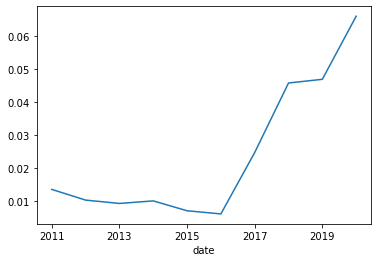

In [221]:
df_ges.de.plot()

In [225]:
df_ges.curr.mean()

2.7776945230445884

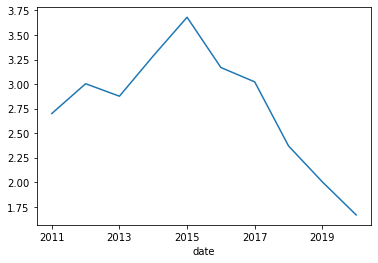

In [224]:
df_ges.curr.plot()

In [228]:
df_ges.roe.mean()

0.11477958284135485

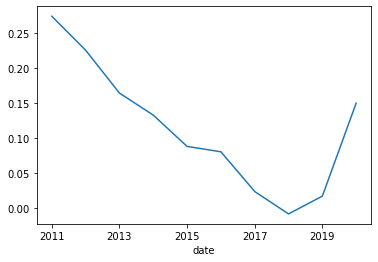

In [227]:
df_ges.roe.plot()

In [229]:
df_ges.intCov

date
2011    332.483977
2012    198.419081
2013    167.393293
2014    115.749870
2015     53.127426
2016     62.135177
2017     11.970480
2018     26.809132
2019     15.324919
2020      8.721619
Name: intCov, dtype: float64

In [231]:
df_ges[['revenue','totalAssets','operatingIncome','totalLiabilities','netCashUsedForInvestingActivites','ocf','fcf']].agg(
    ['mean',lambda x: annual_growth(x[-1],x[0],18)])

,revenue,totalAssets,operatingIncome,totalLiabilities,netCashUsedForInvestingActivites,ocf,fcf
mean,2.488664e+06,1.741666e+06,182700.600000,748933.000000,-59056.60000,3.243011,1.840320
<lambda>,4.114864e-03,2.049732e-02,-0.057008,0.059618,-0.05144,-0.030616,-0.026609


In [232]:
df_ges[['fcf','ocf']]

,fcf,ocf
date,,
2011,3.349394,5.248091
2012,3.630667,5.522636
2013,2.565348,4.074303
2014,3.825818,4.968818
2015,1.247394,2.330697
2016,1.448258,2.718621
2017,-0.289773,1.082667
2018,0.965379,2.248030
2019,-0.400576,1.237561


In [241]:
annual_growth(1.115061,1.033606,4 )

0.019144819358413834

In [240]:
df_ges['div']

date
2011    3.743909
2012    1.126833
2013    2.618152
2014    1.033606
2015    1.166742
2016    1.164545
2017    1.159136
2018    1.152379
2019    1.115061
2020    0.638409
Name: div, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126ed0b50>,
      dtype=object)

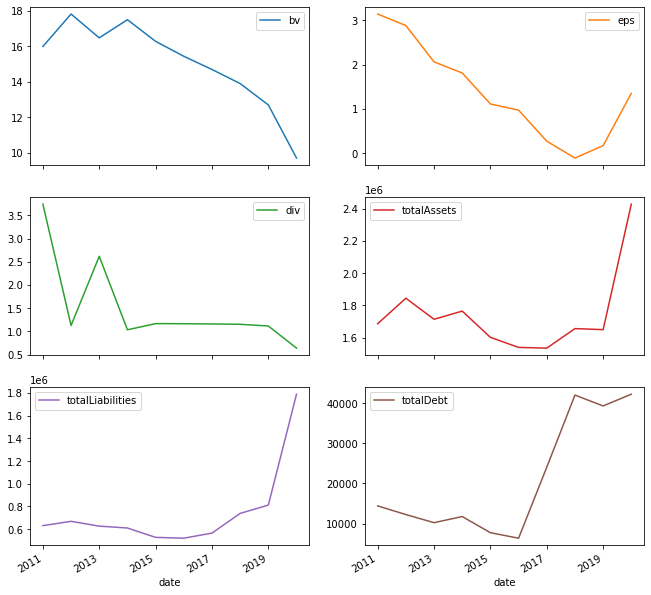

In [242]:
df_ges[['bv','eps','div','totalAssets','totalLiabilities','totalDebt']].plot(subplots = True,
                                                                            figsize = (11,11),
                                                                            layout = (3,-1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1271b9e10>,
      dtype=object)

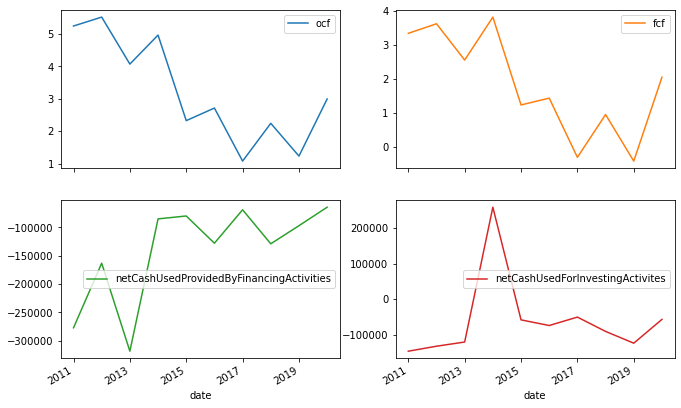

In [243]:
df_ges[['ocf','fcf','netCashUsedProvidedByFinancingActivities','netCashUsedForInvestingActivites']].plot(subplots = True,
                                                                            figsize = (11,11),
                                                                            layout = (3,-1))

In [245]:
df_ges['gcf']

date
2011    0.421807
2012    0.362409
2013    0.447230
2014    0.792244
2015    0.375951
2016    0.410998
2017    0.699633
2018    0.608930
2019    1.512359
2020    0.285332
Name: gcf, dtype: float64

In [247]:
df_ges[['fcf','ocf']].mean()

fcf    1.840320
ocf    3.243011
dtype: float64

In [248]:
df_ges.ownerCash

date
2011    0.088876
2012    0.089144
2013    0.063685
2014    0.098259
2015    0.034053
2016    0.043363
2017   -0.008656
2018    0.026955
2019   -0.010131
2020    0.050799
Name: ownerCash, dtype: float64

In [252]:
df_ges.freeCashFlow.mean()

121461.1

In [256]:
#cf 
cf_ests = [121461.1,115815.0]
grs = [0.05,0.08]
drs = [0.15,0.2,0.25]


In [257]:
intrn_avg(intrinsic_cash(cf_ests,grs,drs,0.03,df_ges.shares.values[0],7))

defaultdict(float,
            {'121.4611,5.0%': 12.443984233876284,
             '121.4611,8.0%': 14.421084110079448,
             '115.815,5.0%': 11.86552759728326,
             '115.815,8.0%': 13.750722298817081})

In [262]:
intrinsic_bk(1.5,15,0.03,0.15,7)

13.175956707468039

# gil 

In [264]:
dict_dal_cash,errs_dal = url_import(['DAL'], 'cash-flow-statement')
dict_dal_balance,errs_dal = url_import(['DAL'], 'balance-sheet-statement')
dict_dal_income,errs_dal = url_import(['DAL'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/DAL?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/DAL?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/DAL?apikey=cb3b0c371586d9ce915d359479fe1c81


In [265]:
df_dal_cash = pd.DataFrame(dict_dal_cash)
df_dal_bal = pd.DataFrame(dict_dal_balance)
df_dal_income = pd.DataFrame(dict_dal_income)

In [266]:
df_dal_bal.date = df_dal_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_dal_cash.date = df_dal_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_dal_income.date = df_dal_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [267]:
df_dal_bal.set_index(['date'], inplace = True)
df_dal_cash.set_index(['date'], inplace = True)
df_dal_income.set_index(['date'], inplace = True)

In [268]:
df_dal_cash.drop('netIncome',axis = 1, inplace = True)

In [269]:
df_dal_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [270]:
df_dal = pd.concat([df_dal_income,df_dal_bal,df_dal_cash],axis = 1)

In [271]:
df_dal.drop(['symbol','period'],axis = 1, inplace =True)

In [272]:
df_dal['shares'] = 637.8E06

In [273]:
df_dal.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [274]:
df_dal = df_dal/1000

In [275]:
df_dal[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_dal[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [276]:
df_dal = df_dal.sort_index()

In [277]:
df_dal_main = df_dal.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [278]:
df_dal_main['netIncome'] = df_dal_income['netIncome'] / 1000

# PRINC 1

In [279]:
df_dal = metrics(df_dal)

In [282]:
df_dal.de.median()

0.7138890918389713

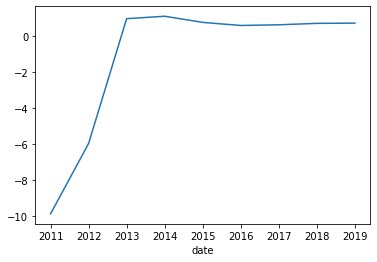

In [281]:
df_dal.de.plot()

In [285]:
df_dal.curr.mean()

0.5366537921761261

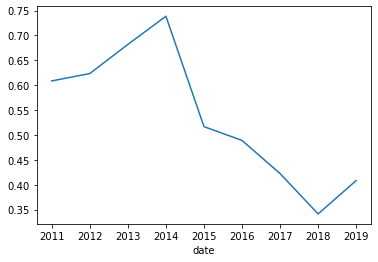

In [284]:
df_dal.curr.plot()

In [287]:
df_dal.interestExpense

date
2010         0.0
2011         0.0
2012    812000.0
2013    698000.0
2014    650000.0
2015    481000.0
2016    388000.0
2017    396000.0
2018         0.0
2019         0.0
Name: interestExpense, dtype: float64

In [291]:
df_dal.roe.median()

0.2874990867246292

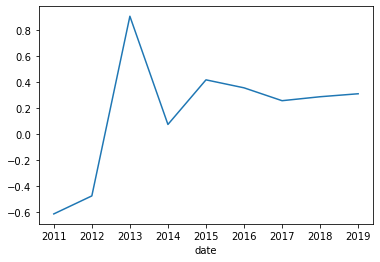

In [289]:
df_dal.roe.plot()

In [292]:
df_ges[['totalAssets','totalLiabilities','ocf','fcf','shortTermDebt']].apply(lambda x: 
                                                                            annual_growth(
                                                                            x[-1],x[3],6))

totalAssets         0.054717
totalLiabilities    0.196465
ocf                -0.080723
fcf                -0.097939
shortTermDebt       0.147349
dtype: float64

In [294]:
df_dal[['ocf','fcf']].apply(lambda x: annual_growth(x[-1],x[2],7))

ocf    0.191171
fcf    0.052608
dtype: float64

In [295]:
df_dal['debtRatio']

date
2010         NaN
2011    0.317042
2012    0.285275
2013    0.217063
2014    0.180651
2015    0.156755
2016    0.143033
2017    0.165766
2018    0.162131
2019    0.172937
Name: debtRatio, dtype: float64

In [305]:
annual_growth(1.536532,0.159925,9)

0.28582120416581125

In [304]:
df_dal['div']

date
2010    0.000000
2011    0.000000
2012    0.000000
2013    0.159925
2014    0.393540
2015    0.562872
2016    0.798056
2017    1.146127
2018    1.425212
2019    1.536532
Name: div, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127849c50>,
      dtype=object)

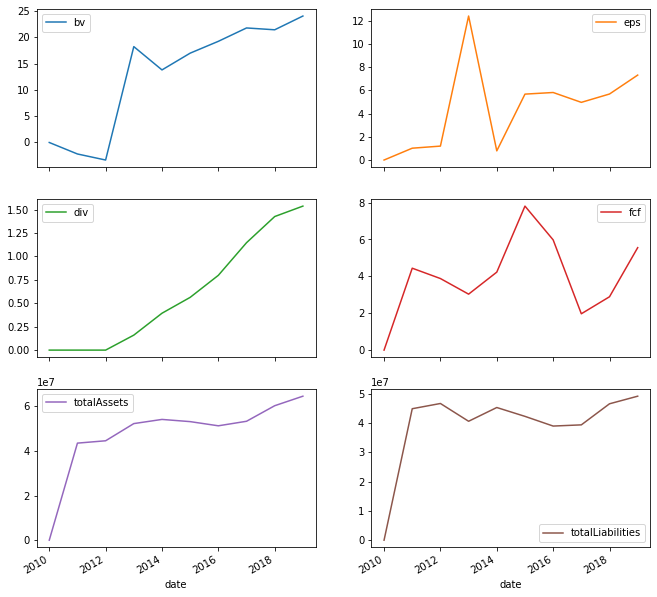

In [307]:
df_dal[['bv','eps','div','fcf','totalAssets','totalLiabilities']].plot(figsize = (11,11),
                                                                  layout = (3,-1),
                                                                  subplots = True)

In [309]:
df_dal[['netCashUsedProvidedByFinancingActivities','netCashUsedForInvestingActivites']]

,netCashUsedProvidedByFinancingActivities,netCashUsedForInvestingActivites
date,,
2010,0.0,0.0
2011,-1571000.0,-1498000.0
2012,-755000.0,-1962000.0
2013,-1320000.0,-2756000.0
2014,-3240000.0,-2463000.0
2015,-4088000.0,-3955000.0
2016,-4260000.0,-2155000.0
2017,-730000.0,-5366000.0
2018,-1726000.0,-3723000.0


In [310]:
# prices 
df_dal = price_ratios(df_dal, 24)

In [313]:
df_dal[['pe','pb','ps']].median()

pe    4.527163
pb    1.182090
ps    0.382706
dtype: float64

In [315]:
annual_growth(3545000.0,2476000.0,7)

0.05260763101661192

In [319]:
df_dal.freeCashFlow.median()

2587000.0

In [328]:
cf_ests = [2587000.0]
grs = [0.03,0.07]
drs = [0.1,0.15,0.2]

In [329]:
intrn_avg(intrinsic_cash(cf_ests, grs, drs,0.03, df_dal.shares.values[0],8))

defaultdict(float,
            {'2587.0,3.0%': 38.09966544284345,
             '2587.0,7.000000000000001%': 48.67293334396373})

In [327]:
intrinsic_bk(0.5, 18,0.15,0.15,8)

20.243660753846108

# aerospace 
# txt

In [330]:
dict_txt_cash,errs_txt = url_import(['TXT'], 'cash-flow-statement')
dict_txt_balance,errs_txt = url_import(['TXT'], 'balance-sheet-statement')
dict_txt_income,errs_txt = url_import(['TXT'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/TXT?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/TXT?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/TXT?apikey=cb3b0c371586d9ce915d359479fe1c81


In [331]:
df_txt_cash = pd.DataFrame(dict_txt_cash)
df_txt_bal = pd.DataFrame(dict_txt_balance)
df_txt_income = pd.DataFrame(dict_txt_income)

In [332]:
df_txt_bal.date = df_txt_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_txt_cash.date = df_txt_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_txt_income.date = df_txt_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [333]:
df_txt_bal.set_index(['date'], inplace = True)
df_txt_cash.set_index(['date'], inplace = True)
df_txt_income.set_index(['date'], inplace = True)

In [334]:
df_txt_cash.drop('netIncome',axis = 1, inplace = True)

In [335]:
df_txt_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [336]:
df_txt = pd.concat([df_txt_income,df_txt_bal,df_txt_cash],axis = 1)

In [337]:
df_txt.drop(['symbol','period'],axis = 1, inplace =True)

In [338]:
df_txt['shares'] = 227.6E06

In [339]:
df_txt.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [340]:
df_txt = df_txt/1000

In [341]:
df_txt[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_txt[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [342]:
df_txt = df_txt.sort_index()

In [343]:
df_txt_main = df_txt.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

# prin 1 

In [348]:
df_txt = metrics(df_txt)

In [349]:
df_txt.de

date
2010         NaN
2011   -1.000000
2011         NaN
2012    0.769308
2013    0.440465
2015    0.658006
2016    0.498206
2016    0.543312
2017    0.546839
2018    0.590524
2020    0.566147
Name: de, dtype: float64

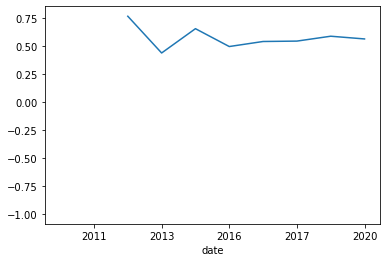

In [350]:
df_txt.de.plot()

In [352]:
df_txt.curr.median()

1.811713331620858

In [353]:
df_txt.intCov

date
2010    0.000000
2011    0.000000
2011    0.000000
2012    2.778302
2013    2.878613
2015    4.465969
2016    5.034483
2016    5.745562
2017    4.379310
2018    8.337349
2020    5.508772
Name: intCov, dtype: float64

In [357]:
df_txt.roe.median()

0.1404494382022472

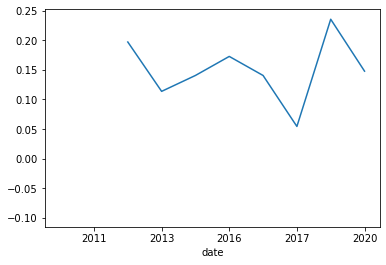

In [356]:
df_txt.roe.plot()

In [358]:
df_txt.roi

date
2010         NaN
2011         inf
2011         NaN
2012    0.045193
2013    0.038473
2015    0.041082
2016    0.062638
2016    0.047389
2017    0.020013
2018    0.085670
2020    0.054268
Name: roi, dtype: float64

In [359]:
df_txt[['totalAssets','totalLiabilities','totalDebt','operatingIncome','fcf']].apply(lambda x:
                                                                                    annual_growth(x[-1],x[3],7))

totalAssets         0.020459
totalLiabilities   -0.007895
totalDebt           0.044650
operatingIncome     0.069384
fcf                 0.060647
dtype: float64

In [360]:
df_txt['invTurnOver']

date
2010         NaN
2011         NaN
2011         NaN
2012    3.694322
2013    3.419170
2015    2.907587
2016    2.533826
2016    2.649373
2017    2.842169
2018    3.036668
2020    2.803146
Name: invTurnOver, dtype: float64

In [363]:
df_txt['recTurnOver']

date
2010          NaN
2011          NaN
2011          NaN
2012    14.761158
2013    12.363636
2015    13.408696
2016    12.958647
2016    12.820439
2017    10.416728
2018    13.644531
2020    14.799131
Name: recTurnOver, dtype: float64

In [367]:
df_txt['gcf']

date
2010         NaN
2011         NaN
2011         NaN
2012    0.412082
2013    0.333333
2015    1.588576
2016    0.516798
2016    0.355963
2017    0.694648
2018    0.543812
2020    0.262327
Name: gcf, dtype: float64

In [369]:
df_txt[['bv','div']].agg(['mean',lambda x: annual_growth(x[-1],x[3],8)])

,bv,div
mean,14.412446,0.067902
<lambda>,0.079557,0.007170


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12809abd0>,
      dtype=object)

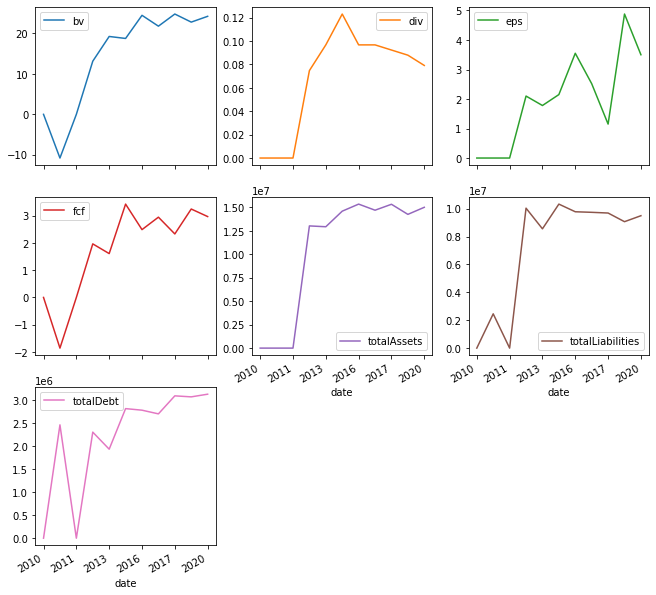

In [370]:
df_txt[['bv','div','eps','fcf','totalAssets','totalLiabilities','totalDebt']].plot(figsize = (11,11)
                                                                                  ,layout = (3,-1),
                                                                                  subplots = True)

In [372]:
df_txt = price_ratios(df_txt,26)

In [375]:
df_txt[['pe','ps','pb','pocf','pfcf']].median()

pe      12.380952
ps       0.440855
pb       1.192103
pocf     6.209444
pfcf    10.455124
dtype: float64

In [381]:
annual_growth(675000,447000.0,8)

0.05286946650255886

In [380]:
df_txt.freeCashFlow

date
2010         0.0
2011   -423000.0
2011         0.0
2012    447000.0
2013    366000.0
2015    779000.0
2016    566000.0
2016    670000.0
2017    530000.0
2018    738000.0
2020    675000.0
Name: freeCashFlow, dtype: float64

In [382]:
cf_ests = [530000,675000]
grs = [0.04,0.06]
lgr = 0.03
drs =[0.1,0.15,0.2]

In [384]:
intrn_avg(intrinsic_cash(cf_ests,grs,drs,lgr,df_txt.shares.values[0],8))

defaultdict(float,
            {'530.0,4.0%': 23.246656821475053,
             '530.0,6.0%': 26.27573446713386,
             '675.0,4.0%': 29.60659123489747,
             '675.0,6.0%': 33.4643788024818})

In [386]:
intrinsic_bk(0.07,15,0.07,0.15,8)

8.739284155313833

# ATRO


In [387]:
dict_atr_cash,errs_atr = url_import(['ATRO'], 'cash-flow-statement')
dict_atr_balance,errs_atr = url_import(['ATRO'], 'balance-sheet-statement')
dict_atr_income,errs_atr = url_import(['ATRO'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/ATRO?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/ATRO?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/ATRO?apikey=cb3b0c371586d9ce915d359479fe1c81


In [388]:
df_atr_cash = pd.DataFrame(dict_atr_cash)
df_atr_bal = pd.DataFrame(dict_atr_balance)
df_atr_income = pd.DataFrame(dict_atr_income)

In [389]:
df_atr_bal.date = df_atr_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_atr_cash.date = df_atr_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_atr_income.date = df_atr_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [390]:
df_atr_bal.set_index(['date'], inplace = True)
df_atr_cash.set_index(['date'], inplace = True)
df_atr_income.set_index(['date'], inplace = True)

In [391]:
df_atr_cash.drop('netIncome',axis = 1, inplace = True)

In [392]:
df_atr_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [393]:
df_atr = pd.concat([df_atr_income,df_atr_bal,df_atr_cash],axis = 1)

In [394]:
df_atr.drop(['symbol','period'],axis = 1, inplace =True)

In [395]:
df_atr['shares'] = 23.28E06

In [396]:
df_atr.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [397]:
df_atr = df_atr/1000

In [398]:
df_atr[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_atr[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [399]:
df_atr = df_atr.sort_index()

In [400]:
df_atr_main = df_atr.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [401]:
df_atr_main['netIncome'] = df_atr_income['netIncome'] / 1000

# PRINC

In [402]:
df_atr = metrics(df_atr)

In [405]:
df_atr.de.mean()

0.6408837529445244

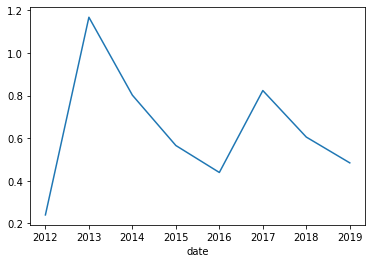

In [404]:
df_atr.de.plot()

In [407]:
df_atr.curr.mean()

2.644354033279113

In [410]:
df_atr.roe.mean()

0.15762507214619909

In [411]:
df_atr.roi

date
2011         NaN
2012    0.103185
2013    0.055501
2014    0.099785
2015    0.109930
2016    0.080127
2017    0.026739
2018    0.060419
2019    0.066457
Name: roi, dtype: float64

In [412]:
df_atr[['totalAssets','totalLiabilities','totalDebt','ocf']].apply(lambda x: 
                                                                   annual_growth(x[-1],x[1],8))

totalAssets         0.177366
totalLiabilities    0.208004
totalDebt           0.258128
ocf                 0.073648
dtype: float64

In [413]:
df_atr.debtRatio

date
2011         NaN
2012    0.141437
2013    0.407759
2014    0.325111
2015    0.278688
2016    0.245092
2017    0.369271
2018    0.302053
2019    0.240475
Name: debtRatio, dtype: float64

In [416]:
df_atr.fcf

date
2011    0.000000
2012    0.320361
2013    1.833376
2014    2.534021
2015    2.571306
2016    1.538531
2017    1.044029
2018    1.656529
2019    1.314691
Name: fcf, dtype: float64

# maxr 

In [417]:
dict_max_cash,errs_max = url_import(['MAXR'], 'cash-flow-statement')
dict_max_balance,errs_max = url_import(['MAXR'], 'balance-sheet-statement')
dict_max_income,errs_max = url_import(['MAXR'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/MAXR?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/MAXR?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/MAXR?apikey=cb3b0c371586d9ce915d359479fe1c81


In [418]:
df_max_cash = pd.DataFrame(dict_max_cash)
df_max_bal = pd.DataFrame(dict_max_balance)
df_max_income = pd.DataFrame(dict_max_income)

In [419]:
df_max_bal.date = df_max_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_max_cash.date = df_max_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_max_income.date = df_max_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [420]:
df_max_bal.set_index(['date'], inplace = True)
df_max_cash.set_index(['date'], inplace = True)
df_max_income.set_index(['date'], inplace = True)

In [421]:
df_max_cash.drop('netIncome',axis = 1, inplace = True)

In [422]:
df_max_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [423]:
df_max = pd.concat([df_max_income,df_max_bal,df_max_cash],axis = 1)

In [424]:
df_max.drop(['symbol','period'],axis = 1, inplace =True)

In [425]:
df_max['shares'] = 60.4E06

In [426]:
df_max.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [427]:
df_max = df_max/1000

In [428]:
df_max[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_max[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [429]:
df_max = df_max.sort_index()

In [430]:
df_max_main = df_max.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [431]:
df_max_main['netIncome'] = df_max_income['netIncome'] / 1000

# prin 

In [432]:
df_max = metrics(df_max)

In [433]:
df_max.de

date
2018    4.738725
2019    3.869908
Name: de, dtype: float64

In [434]:
df_max.roe

date
2018   -1.965785
2019    0.143233
Name: roe, dtype: float64

In [435]:
df_max.curr

date
2018    0.750294
2019    1.266064
Name: curr, dtype: float64

In [437]:
df_max.intCov

date
2018   -5.569307
2019         inf
Name: intCov, dtype: float64

In [438]:
df_max.fcf

date
2018   -1.307947
2019    0.049669
Name: fcf, dtype: float64

# air

In [439]:
dict_air_cash,errs_air = url_import(['AIR'], 'cash-flow-statement')
dict_air_balance,errs_air = url_import(['AIR'], 'balance-sheet-statement')
dict_air_income,errs_air = url_import(['AIR'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/AIR?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/AIR?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/AIR?apikey=cb3b0c371586d9ce915d359479fe1c81


In [450]:
df_air_cash = pd.DataFrame(dict_air_cash)
df_air_bal = pd.DataFrame(dict_air_balance)
df_air_income = pd.DataFrame(dict_air_income)

In [451]:
df_air_bal.date = df_air_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_air_cash.date = df_air_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_air_income.date = df_air_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [452]:
df_air_bal.set_index(['date'], inplace = True)
df_air_cash.set_index(['date'], inplace = True)
df_air_income.set_index(['date'], inplace = True)

In [453]:
df_air_cash.drop('netIncome',axis = 1, inplace = True)

In [454]:
df_air_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [455]:
df_air = pd.concat([df_air_income,df_air_bal,df_air_cash],axis = 1)

In [456]:
df_air.drop(['symbol','period'],axis = 1, inplace =True)

In [457]:
df_air['shares'] = 35E06

In [458]:
df_air.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [459]:
df_air = df_air/1000

In [460]:
df_air[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_air[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [461]:
df_air = df_air.sort_index()

In [462]:
df_air_main = df_air.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [463]:
df_air_main['netIncome'] = df_air_income['netIncome'] / 1000

# PRINC

In [464]:
df_air = metrics(df_air)

In [465]:
df_air.de

date
2011    0.389192
2012    0.000197
2013    0.771391
2014    0.634317
2015    0.182227
2016    0.171056
2017    0.172063
2018    0.199829
2019    0.166906
Name: de, dtype: float64

In [466]:
df_air.de.mean()

0.2985752644599031

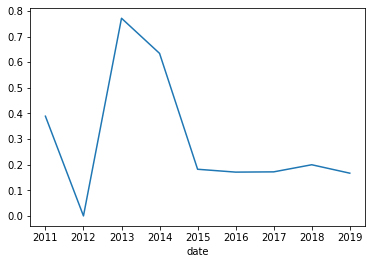

In [467]:
df_air.de.plot()

In [468]:
df_air.curr

date
2011    2.197027
2012    2.246859
2013    2.657326
2014    2.777667
2015    2.315777
2016    2.653799
2017    2.651447
2018    2.828383
2019    2.664336
Name: curr, dtype: float64

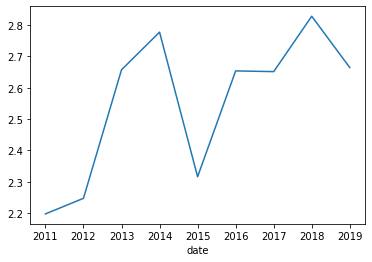

In [469]:
df_air.curr.plot()

In [471]:
df_air.intCov.mean()

3.1086322739930385

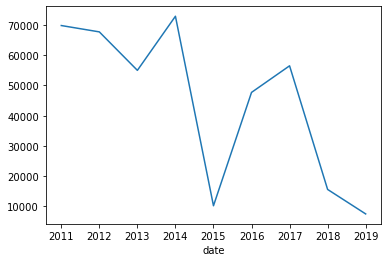

In [474]:
df_air.operatingIncome.plot()

In [476]:
df_air.roe.mean()

0.04984222855315485

In [478]:
df_air.netIncome

date
2011    69826.0
2012    67723.0
2013    55000.0
2014    72900.0
2015    10200.0
2016    47700.0
2017    56500.0
2018    15600.0
2019     7500.0
Name: netIncome, dtype: float64

In [479]:
df_air.fcf

date
2011   -0.465171
2012    0.085686
2013    3.580000
2014    3.237143
2015   -2.551429
2016   -1.608571
2017   -0.337143
2018    1.208571
2019    1.428571
Name: fcf, dtype: float64

# hwm 

In [480]:
dict_hwm_cash,errs_hwm = url_import(['HWM'], 'cash-flow-statement')
dict_hwm_balance,errs_hwm = url_import(['HWM'], 'balance-sheet-statement')
dict_hwm_income,errs_hwm = url_import(['HWM'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/HWM?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/HWM?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/HWM?apikey=cb3b0c371586d9ce915d359479fe1c81


In [481]:
df_hwm_cash = pd.DataFrame(dict_hwm_cash)
df_hwm_bal = pd.DataFrame(dict_hwm_balance)
df_hwm_income = pd.DataFrame(dict_hwm_income)

In [482]:
df_hwm_bal.date = df_hwm_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_hwm_cash.date = df_hwm_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_hwm_income.date = df_hwm_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [483]:
df_hwm_bal.set_index(['date'], inplace = True)
df_hwm_cash.set_index(['date'], inplace = True)
df_hwm_income.set_index(['date'], inplace = True)

In [484]:
df_hwm_cash.drop('netIncome',axis = 1, inplace = True)

In [485]:
df_hwm_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [486]:
df_hwm = pd.concat([df_hwm_income,df_hwm_bal,df_hwm_cash],axis = 1)

In [487]:
df_hwm.drop(['symbol','period'],axis = 1, inplace =True)

In [488]:
df_hwm['shares'] = 436E06

In [489]:
df_hwm.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [490]:
df_hwm = df_hwm/1000

In [491]:
df_hwm[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_hwm[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [492]:
df_hwm = df_hwm.sort_index()

In [493]:
df_hwm_main = df_hwm.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [494]:
df_hwm_main['netIncome'] = df_hwm_income['netIncome'] / 1000

# PRIN

In [495]:
df_hwm = metrics(df_hwm)

In [499]:
df_hwm.de

date
2010    0.666593
2011    0.656241
2012         NaN
2013         NaN
2014    0.714936
2015    0.752532
2016    1.573412
2017    1.393890
2018    1.135833
2019    1.289342
Name: de, dtype: float64

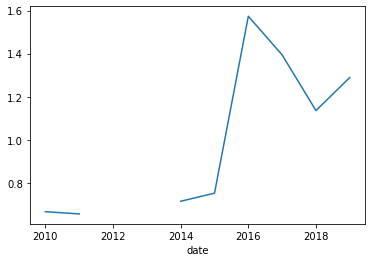

In [497]:
df_hwm.de.plot()

In [501]:
df_hwm.curr.mean()

1.662556179900914

In [503]:
df_hwm.intCov.median()

0.7434586915767019

In [505]:
df_hwm.operatingIncome

date
2010     254000.0
2011    1063000.0
2012          0.0
2013          0.0
2014     268000.0
2015    -322000.0
2016     414000.0
2017     326000.0
2018    1325000.0
2019    1035000.0
Name: operatingIncome, dtype: float64

In [507]:
df_hwm.roe.median()

0.020219685650903076

In [508]:
df_hwm.roi

date
2010    0.006464
2011    0.015229
2012         NaN
2013         NaN
2014    0.007166
2015   -0.008815
2016   -0.046961
2017   -0.003953
2018    0.034344
2019    0.026738
Name: roi, dtype: float64

In [509]:
df_hwm[['totalAssets','totalLiabilities','operatingIncome','totalDebt']].apply(lambda x: 
                                                                              annual_growth(x[-1],x[0],10))

totalAssets        -0.077290
totalLiabilities   -0.066027
operatingIncome     0.150829
totalDebt          -0.041475
dtype: float64

In [ ]:
annual_growth

In [511]:
df_atr.freeCashFlow

date
2011        0.0
2012     7458.0
2013    42681.0
2014    58992.0
2015    59860.0
2016    35817.0
2017    24305.0
2018    38564.0
2019    30606.0
Name: freeCashFlow, dtype: float64

In [513]:
annual_growth(16.703479, 5.375172,7)

0.17583108834056316

In [514]:
df_atr.bv.mean()

10.824279305078274

In [517]:
df_atr.freeCashFlow

date
2011        0.0
2012     7458.0
2013    42681.0
2014    58992.0
2015    59860.0
2016    35817.0
2017    24305.0
2018    38564.0
2019    30606.0
Name: freeCashFlow, dtype: float64

In [516]:
df_atr.shortTermDebt

date
2011        0.0
2012     9268.0
2013    12279.0
2014     2796.0
2015     2579.0
2016     2636.0
2017     2689.0
2018     1870.0
2019      224.0
Name: shortTermDebt, dtype: float64

In [518]:
df_atr['div']

date
2011    0.0
2012    0.0
2013    0.0
2014    0.0
2015    0.0
2016    0.0
2017    0.0
2018    0.0
2019    0.0
Name: div, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129b84610>,
      dtype=object)

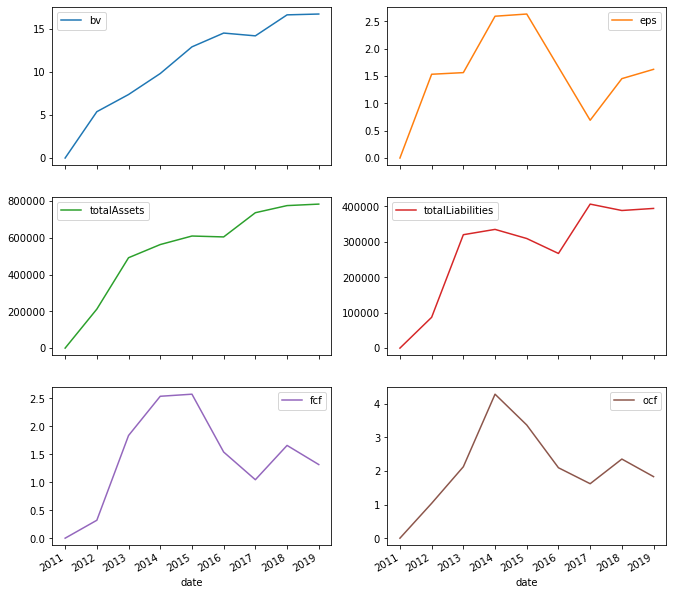

In [520]:
df_atr[['bv','eps','totalAssets','totalLiabilities','fcf','ocf']].plot(subplots = True, 
                                                                      figsize = (11,11),
                                                                    layout = (3,-1))

In [521]:
df_atr = price_ratios(df_atr,8)

In [523]:
df_atr.gcf

date
2011         NaN
2012    1.132393
2013    3.361259
2014    1.103380
2015    0.937389
2016    0.299300
2017    3.429082
2018    0.358357
2019    1.513973
Name: gcf, dtype: float64

In [526]:
df_atr[['pe','ps','pb','pocf']].median()

pe      5.128205
ps      0.294161
pb      0.620335
pocf    3.812175
dtype: float64

In [528]:
annual_growth(30606,7458.0,7)

0.22348244449291377

In [539]:
cf_ets = [df_atr.freeCashFlow.median()]
grs = [0.05,0.1]
drs= [0.1,0.15]
lgr = 0.03


In [540]:
df_atr.freeCashFlow / df_atr.shares

date
2011    0.000000
2012    0.320361
2013    1.833376
2014    2.534021
2015    2.571306
2016    1.538531
2017    1.044029
2018    1.656529
2019    1.314691
dtype: float64

In [541]:
intrn_avg(intrinsic_cash(cf_ets, grs,drs,lgr,df_atr.shares.values[0],7))

defaultdict(float,
            {'35.817,5.0%': 19.285228439819782,
             '35.817,10.0%': 25.85647976183205})

In [544]:
intrinsic_bk(0,11,0.1,0.1,7)

11.0

# ati

In [545]:
dict_ati_cash,errs_ati = url_import(['ATI'], 'cash-flow-statement')
dict_ati_balance,errs_ati = url_import(['ATI'], 'balance-sheet-statement')
dict_ati_income,errs_ati = url_import(['ATI'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/ATI?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/ATI?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/ATI?apikey=cb3b0c371586d9ce915d359479fe1c81


In [546]:
df_ati_cash = pd.DataFrame(dict_ati_cash)
df_ati_bal = pd.DataFrame(dict_ati_balance)
df_ati_income = pd.DataFrame(dict_ati_income)

In [547]:
df_ati_bal.date = df_ati_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_ati_cash.date = df_ati_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_ati_income.date = df_ati_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [548]:
df_ati_bal.set_index(['date'], inplace = True)
df_ati_cash.set_index(['date'], inplace = True)
df_ati_income.set_index(['date'], inplace = True)

In [549]:
df_ati_cash.drop('netIncome',axis = 1, inplace = True)

In [550]:
df_ati_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [551]:
df_ati = pd.concat([df_ati_income,df_ati_bal,df_ati_cash],axis = 1)

In [552]:
df_ati.drop(['symbol','period'],axis = 1, inplace =True)

In [553]:
df_ati['shares'] = 126.6E06

In [554]:
df_ati.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [555]:
df_ati = df_ati/1000

In [556]:
df_ati[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_ati[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [557]:
df_ati = df_ati.sort_index()

In [558]:
df_ati_main = df_ati.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [559]:
df_ati_main['netIncome'] = df_ati_income['netIncome'] / 1000

# PRIN

In [561]:
df_ati = metrics(df_ati)

In [563]:
df_ati.de.mean()

0.7464140581147066

In [564]:
df_ati.curr

date
2010    2.673957
2011    2.981550
2012    2.880780
2013    2.436664
2014    2.585790
2015    2.720466
2016    2.492592
2017    2.688324
2018    2.684550
2019    2.711964
Name: curr, dtype: float64

In [565]:
df_ati.intCov

date
2010       inf
2011       inf
2012       inf
2013      -inf
2014       inf
2015      -inf
2016      -inf
2017       inf
2018    1207.0
2019     732.2
Name: intCov, dtype: float64

In [566]:
df_ati.debtRatio

date
2010    0.236625
2011    0.249599
2012    0.236899
2013    0.282279
2014    0.231960
2015    0.260045
2016    0.363056
2017    0.297123
2018    0.280290
2019    0.248270
Name: debtRatio, dtype: float64

In [570]:
df_ati.roe.median()

0.043926572579051505

In [574]:
df_ati.fcf

date
2010   -1.516588
2011    0.146919
2012    0.359400
2013   -1.929700
2014   -1.341232
2015   -0.103476
2016   -1.942338
2017   -0.792259
2018    2.003160
2019    0.488942
Name: fcf, dtype: float64

# insurance

In [577]:
dict_gbl_cash,errs_gbl = url_import(['GBLI'], 'cash-flow-statement')
dict_gbl_balance,errs_gbl = url_import(['GBLI'], 'balance-sheet-statement')
dict_gbl_income,errs_gbl = url_import(['GBLI'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/GBLI?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/GBLI?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/GBLI?apikey=cb3b0c371586d9ce915d359479fe1c81


In [607]:
df_gbl_cash = pd.DataFrame(dict_gbl_cash)
df_gbl_bal = pd.DataFrame(dict_gbl_balance)
df_gbl_income = pd.DataFrame(dict_gbl_income)

In [608]:
df_gbl_bal.date = df_gbl_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_gbl_cash.date = df_gbl_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_gbl_income.date = df_gbl_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [609]:
df_gbl_bal.set_index(['date'], inplace = True)
df_gbl_cash.set_index(['date'], inplace = True)
df_gbl_income.set_index(['date'], inplace = True)

In [610]:
df_gbl_cash.drop('netIncome',axis = 1, inplace = True)

In [611]:
df_gbl_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [612]:
df_gbl = pd.concat([df_gbl_income,df_gbl_bal,df_gbl_cash],axis = 1)

In [613]:
df_gbl.drop(['symbol','period'],axis = 1, inplace =True)

In [614]:
df_gbl['shares'] = 14.32E06

In [615]:
df_gbl.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [616]:
df_gbl = df_gbl/1000

In [617]:
df_gbl[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_gbl[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [618]:
df_gbl = df_gbl.sort_index()

In [619]:
df_gbl_main = df_gbl.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [620]:
df_gbl_main['netIncome'] = df_gbl_income['netIncome'] / 1000

# PRIN

In [621]:
df_gbl= metrics(df_gbl)

In [622]:
df_gbl.de.mean()

0.2772549210599329

In [628]:
df_gbl.intCov

date
2011    -5.804200
2012     5.358984
2013    10.000000
2014    76.467153
2015     8.440668
2016     5.600000
2017    -0.564947
2018    -2.878846
2019     4.083358
Name: intCov, dtype: float64

In [624]:
df_gbl.interestExpense

date
2011     6476.0
2012     5393.0
2013     6169.0
2014      822.0
2015     4913.0
2016     8905.0
2017    16906.0
2018    19694.0
2019    20022.0
Name: interestExpense, dtype: float64

In [625]:
annual_growth(20022., 6169.0,6)

0.2167894842554403

In [630]:
df_gbl.roe

date
2011   -0.047083
2012    0.043090
2013    0.070642
2014    0.069203
2015    0.055297
2016    0.062495
2017   -0.013295
2018   -0.090128
2019    0.096332
Name: roe, dtype: float64

In [634]:
df_gbl.

date
2011   -0.540363
2012   -2.445042
2013   -0.343645
2014   -0.838128
2015    0.261872
2016   -1.703631
2017   -1.651536
2018    2.937779
2019    2.260894
Name: fcf, dtype: float64

In [631]:
df_gbl[['totalAssets','totalLiabilities','totalDebt','operatingIncome','ocf']].apply(lambda x:
                                                                                    annual_growth(
                                                                                    x[-1],x[1],8))

/Applications/anaconda3/envs/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


totalAssets         0.010882
totalLiabilities    0.026182
totalDebt           0.141051
operatingIncome     0.138811
ocf                      NaN
dtype: float64

In [635]:
df_gbl.shortTermDebt

date
2011         0.0
2012     19554.0
2013    100000.0
2014    174673.0
2015         0.0
2016      8759.0
2017     12465.0
2018         0.0
2019      3612.0
Name: shortTermDebt, dtype: float64

In [ ]:
annual_growth(50.754818,)

In [649]:
df_gbl['div']

date
2011    0.000000
2012    0.000000
2013    0.000000
2014    8.729050
2015    0.000000
2016    0.000000
2017    0.000000
2018    0.979539
2019    0.993156
Name: div, dtype: float64

In [646]:
df_gbl.eps

date
2011   -1.31
2012    1.30
2013    2.46
2014    2.50
2015    1.71
2016    2.89
2017   -0.55
2018   -4.02
2019    4.93
Name: eps, dtype: float64

# unm

In [ ]:
v

In [650]:
dict_unm_cash,errs_unm = url_import(['UNM'], 'cash-flow-statement')
dict_unm_balance,errs_unm = url_import(['UNM'], 'balance-sheet-statement')
dict_unm_income,errs_unm = url_import(['UNM'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/UNM?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/UNM?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/UNM?apikey=cb3b0c371586d9ce915d359479fe1c81


In [651]:
df_unm_cash = pd.DataFrame(dict_unm_cash)
df_unm_bal = pd.DataFrame(dict_unm_balance)
df_unm_income = pd.DataFrame(dict_unm_income)

In [652]:
df_unm_bal.date = df_unm_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_unm_cash.date = df_unm_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_unm_income.date = df_unm_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [653]:
df_unm_bal.set_index(['date'], inplace = True)
df_unm_cash.set_index(['date'], inplace = True)
df_unm_income.set_index(['date'], inplace = True)

In [654]:
df_unm_cash.drop('netIncome',axis = 1, inplace = True)

In [655]:
df_unm_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [656]:
df_unm = pd.concat([df_unm_income,df_unm_bal,df_unm_cash],axis = 1)

In [657]:
df_unm.drop(['symbol','period'],axis = 1, inplace =True)

In [658]:
df_unm['shares'] = 203.3E06

In [659]:
df_unm.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [660]:
df_unm = df_unm/1000

In [661]:
df_unm[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_unm[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [662]:
df_unm = df_unm.sort_index()

In [663]:
df_unm_main = df_unm.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [664]:
df_unm_main['netIncome'] = df_unm_income['netIncome'] / 1000

# princ

In [665]:
df_unm = metrics(df_unm)

In [668]:
df_unm.de.mean()

0.33210521630472684

In [669]:
df_unm.debtRatio

date
2010         NaN
2011    0.047899
2012    0.051597
2013    0.045258
2014    0.044492
2015    0.046666
2016    0.048423
2017    0.045902
2018    0.048021
Name: debtRatio, dtype: float64

In [671]:
df_unm.curr.mean()

84.15458341758145

In [672]:
df_unm.intCov

date
2010         NaN
2011    1.794836
2012    6.151307
2013    5.743641
2014    3.147463
2015    8.104058
2016    8.118675
2017    8.780488
2018    3.752540
Name: intCov, dtype: float64

In [674]:
df_unm.roe.median()

0.09959000396367171

In [675]:
df_unm.roi

date
2010         NaN
2011    0.003912
2012    0.014371
2013    0.014445
2014    0.006615
2015    0.014311
2016    0.015037
2017    0.015531
2018    0.008459
Name: roi, dtype: float64

In [677]:
df_unm[['totalAssets','totalLiabilities','totalDebt','operatingIncome','ocf']].apply(lambda x:
                                                                              annual_growth(
                                                                              x[-1],x[1],7))

totalAssets         0.003980
totalLiabilities    0.004511
totalDebt           0.004344
operatingIncome     0.135963
ocf                 0.036722
dtype: float64

In [682]:
df_unm.commonStockRepurchased

date
2010         0.0
2011   -619900.0
2012   -496700.0
2013   -317200.0
2014   -306000.0
2015   -417900.0
2016   -405200.0
2017   -401800.0
2018   -356200.0
Name: commonStockRepurchased, dtype: float64

In [681]:
df_unm.bv.median()

42.40924741760944

In [684]:
annual_growth(1.060502,0.595180,7)

0.08601942848415045

In [685]:
df_unm['div'].median()

0.7840629611411707

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1247f6850>,
      dtype=object)

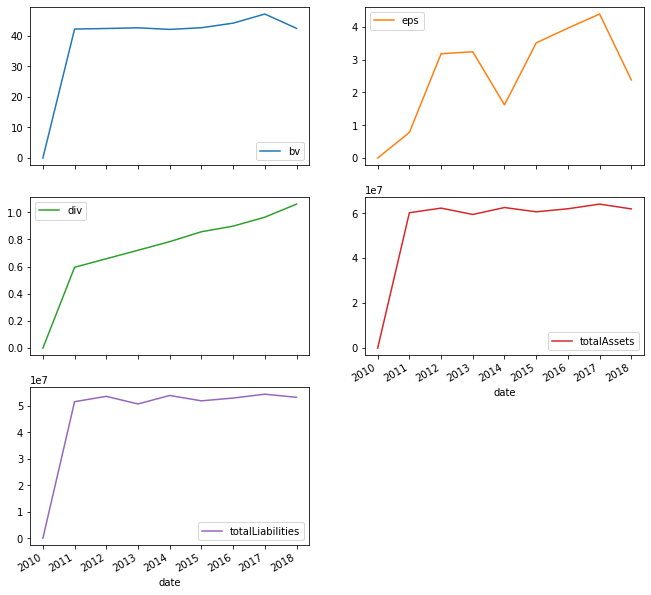

In [686]:
df_unm[['bv','eps','div','totalAssets','totalLiabilities']].plot(subplots = True, 
                                                                figsize = (11,11),
                                                                layout = (3,-1))

In [692]:
df_unm[['fcf','ocf','netCashUsedProvidedByFinancingActivities','netCashUsedForInvestingActivites']].mean()

fcf                                              5.046565
ocf                                              5.423020
netCashUsedProvidedByFinancingActivities   -510466.666667
netCashUsedForInvestingActivites           -587544.444444
dtype: float64

In [691]:
annual_growth(7.825873,4.554845,6)

0.09440112847083926

In [693]:
df_unm.gcf

date
2010         NaN
2011    0.343721
2012    0.807046
2013    0.038682
2014    0.724583
2015    0.551815
2016    0.636144
2017    0.421611
2018    0.605337
Name: gcf, dtype: float64

In [695]:
df_unm = price_ratios(df_unm,16)

In [698]:
df_unm[['pe','ps','pb','pocf']].median()

pe      5.031447
ps      0.309337
pb      0.377276
pocf    2.724973
dtype: float64

In [704]:
cf_ests_unm = [df_unm.freeCashFlow.median()]
grs=[0.04,0.07]
drs = [0.1,0.15]


In [705]:
intrn_avg(intrinsic_cash(cf_ests_unm,grs,drs,0.03,df_unm.shares.values[0],7))

defaultdict(float,
            {'1109.1,4.0%': 64.48423455490868,
             '1109.1,7.000000000000001%': 76.90258111002889})

In [707]:
df_unm['div'].median()

0.7840629611411707

In [714]:
intrinsic_bk(0.8,42,0.05,0.1,7)

34.221465266334704

# manufacturing 
# SCS

In [717]:
dict_dgi_cash,errs_dgi = url_import(['DGICB'], 'cash-flow-statement')
dict_dgi_balance,errs_dgi = url_import(['DGICB'], 'balance-sheet-statement')
dict_dgi_income,errs_dgi = url_import(['DGICB'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/DGICB?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/DGICB?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/DGICB?apikey=cb3b0c371586d9ce915d359479fe1c81


In [718]:
df_dgi_cash = pd.DataFrame(dict_dgi_cash)
df_dgi_bal = pd.DataFrame(dict_dgi_balance)
df_dgi_income = pd.DataFrame(dict_dgi_income)

In [719]:
df_dgi_bal.date = df_dgi_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_dgi_cash.date = df_dgi_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_dgi_income.date = df_dgi_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [720]:
df_dgi_bal.set_index(['date'], inplace = True)
df_dgi_cash.set_index(['date'], inplace = True)
df_dgi_income.set_index(['date'], inplace = True)

In [721]:
df_dgi_cash.drop('netIncome',axis = 1, inplace = True)

In [722]:
df_dgi_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [723]:
df_dgi = pd.concat([df_dgi_income,df_dgi_bal,df_dgi_cash],axis = 1)

In [724]:
df_dgi.drop(['symbol','period'],axis = 1, inplace =True)

In [725]:
df_dgi['shares'] = 5E06

In [726]:
df_dgi.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [727]:
df_dgi = df_dgi/1000

In [728]:
df_dgi[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_dgi[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [729]:
df_dgi = df_dgi.sort_index()

In [730]:
df_dgi_main = df_dgi.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [731]:
df_dgi_main['netIncome'] = df_dgi_income['netIncome'] / 1000

In [732]:
df_dgi = metrics(df_dgi)

In [733]:
df_dgi.roe

date
2011         NaN
2012    0.057727
2013    0.066323
2014    0.034938
2015    0.051397
2016    0.070224
2017    0.015860
2018   -0.082133
2019    0.104546
Name: roe, dtype: float64

In [734]:
df_unm.roe

date
2010         NaN
2011    0.027445
2012    0.103848
2013    0.099098
2014    0.048337
2015    0.100082
2016    0.103858
2017    0.103834
2018    0.060707
Name: roe, dtype: float64

In [735]:
dict_scs_cash,errs_scs = url_import(['SCS'], 'cash-flow-statement')
dict_scs_balance,errs_scs = url_import(['SCS'], 'balance-sheet-statement')
dict_scs_income,errs_scs = url_import(['SCS'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/SCS?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/SCS?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/SCS?apikey=cb3b0c371586d9ce915d359479fe1c81


In [744]:
df_scs_cash = pd.DataFrame(dict_scs_cash)
df_scs_bal = pd.DataFrame(dict_scs_balance)
df_scs_income = pd.DataFrame(dict_scs_income)

In [745]:
df_scs_bal.date = df_scs_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_scs_cash.date = df_scs_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_scs_income.date = df_scs_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [746]:
df_scs_bal.set_index(['date'], inplace = True)
df_scs_cash.set_index(['date'], inplace = True)
df_scs_income.set_index(['date'], inplace = True)

In [747]:
df_scs_cash.drop('netIncome',axis = 1, inplace = True)

In [748]:
df_scs_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [749]:
df_scs = pd.concat([df_scs_income,df_scs_bal,df_scs_cash],axis = 1)

In [750]:
df_scs.drop(['symbol','period'],axis = 1, inplace =True)

In [751]:
df_scs['shares'] = 114.8E06

In [752]:
df_scs.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [753]:
df_scs = df_scs/1000

In [754]:
df_scs[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_scs[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [755]:
df_scs = df_scs.sort_index()

In [756]:
df_scs_main = df_scs.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [757]:
df_scs_main['netIncome'] = df_scs_income['netIncome'] / 1000

# PRINC

In [758]:
df_scs = metrics(df_scs)

In [760]:
df_scs.de.mean()

0.4407054342566172

In [762]:
df_scs.debtRatio.mean()

0.17728006122860304

In [763]:
df_scs.curr

date
2012    1.520026
2013    1.606023
2014    1.653475
2015    1.568861
2016    1.477848
2017    1.565151
2018    1.539391
2019    1.593750
2020    1.720654
Name: curr, dtype: float64

In [764]:
df_scs.intCov

date
2012     3.792969
2013     3.331461
2014     9.320225
2015     8.186441
2016     9.920455
2017    11.639535
2018     8.914286
2019     4.896000
2020     9.413919
Name: intCov, dtype: float64

In [766]:
df_scs.roe.mean()

0.13825320106981334

In [767]:
df_scs.roi

date
2012    0.033333
2013    0.022964
2014    0.050791
2015    0.050006
2016    0.094161
2017    0.069531
2018    0.043406
2019    0.058813
2020    0.077844
Name: roi, dtype: float64

In [768]:
df_scs[['totalAssets','totalLiabilities','totalDebt','operatingIncome']].apply(lambda x: 
                                                                              annual_growth(
                                                                              x[-1],x[0],8))

totalAssets         0.052704
totalLiabilities    0.061107
totalDebt           0.076189
operatingIncome     0.129378
dtype: float64

# KRO

In [777]:
dict_axt_cash,errs_axt = url_import(['AXTA'], 'cash-flow-statement')
dict_axt_balance,errs_axt = url_import(['AXTA'], 'balance-sheet-statement')
dict_axt_income,errs_axt = url_import(['AXTA'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/AXTA?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/AXTA?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/AXTA?apikey=cb3b0c371586d9ce915d359479fe1c81


In [778]:
df_axt_cash = pd.DataFrame(dict_axt_cash)
df_axt_bal = pd.DataFrame(dict_axt_balance)
df_axt_income = pd.DataFrame(dict_axt_income)

In [779]:
df_axt_bal.date = df_axt_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_axt_cash.date = df_axt_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_axt_income.date = df_axt_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [780]:
df_axt_bal.set_index(['date'], inplace = True)
df_axt_cash.set_index(['date'], inplace = True)
df_axt_income.set_index(['date'], inplace = True)

In [781]:
df_axt_cash.drop('netIncome',axis = 1, inplace = True)

In [782]:
df_axt_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [783]:
df_axt = pd.concat([df_axt_income,df_axt_bal,df_axt_cash],axis = 1)

In [784]:
df_axt.drop(['symbol','period'],axis = 1, inplace =True)

In [785]:
df_axt['shares'] = 235.3E06

In [786]:
df_axt.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [787]:
df_axt = df_axt/1000

In [788]:
df_axt[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_axt[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [789]:
df_axt = df_axt.sort_index()

In [790]:
df_axt_main = df_axt.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [791]:
df_axt_main['netIncome'] = df_axt_income['netIncome'] / 1000

# AXTA

In [802]:
df_axt = metrics(df_axt)

In [803]:
df_axt.de

date
2014    3.538241
2015    3.205271
2016    2.872899
2017    3.068412
2018    3.206373
Name: de, dtype: float64

In [804]:
df_axt.curr

date
2014    1.978346
2015    2.174796
2016    2.087637
2017    2.139715
2018    2.219489
Name: curr, dtype: float64

In [805]:
df_axt.intCov

date
2014    1.697290
2015    2.386260
2016    2.291246
2017    2.464626
2018    2.770050
Name: intCov, dtype: float64

In [806]:
df_axt.debtRatio

date
2014    0.591159
2015    0.587869
2016    0.557474
2017    0.573110
2018    0.578816
Name: debtRatio, dtype: float64

In [807]:
df_axt.roe.mean()

0.07018018907529504

In [808]:
df_axt.roi

date
2014    0.004382
2015    0.016006
2016    0.007139
2017    0.005372
2018    0.031023
Name: roi, dtype: float64

In [810]:
df_axt.rof.mean()

0.2587920242958913

In [812]:
df_txt = metrics(df_txt)

df_unm=metrics(df_unm)
df_atr = metrics(df_atr)

In [813]:
df_txt[['rof','rocf']]


,rof,rocf
date,,
2010,NaN,NaN
2011,0.172021,-0.000000
2011,NaN,NaN
2012,0.149448,0.309930
2013,0.083485,0.184763
2015,0.182350,0.282772
2016,0.101543,0.181557
2016,0.134972,0.219581
2017,0.093855,0.168762


In [814]:
df_atr[['rof','rocf']]

,rof,rocf
date,,
2011,NaN,NaN
2012,0.059600,0.193217
2013,0.248856,0.288900
2014,0.258536,0.437704
2015,0.199384,0.261474
2016,0.106140,0.144774
2017,0.073668,0.114519
2018,0.099745,0.141949
2019,0.078708,0.109781


In [815]:
df_unm[['rof','rocf']]

,rof,rocf
date,,
2010,NaN,NaN
2011,0.144561,0.139175
2012,0.150849,0.160184
2013,0.106940,0.119123
2014,0.129683,0.143071
2015,0.137571,0.149136
2016,0.114975,0.124454
2017,0.109046,0.120043
2018,0.161498,0.178211


In [817]:
df_hwm = metrics(df_hwm)

In [818]:
df_hwm[['rof','rocf']]

,rof,rocf
date,,
2010,0.091544,0.166116
2011,0.065444,0.158408
2012,NaN,NaN
2013,NaN,NaN
2014,0.036974,0.136031
2015,0.033372,0.131330
2016,-0.049853,0.170088
2017,0.021385,0.142770
2018,-0.098870,0.038938


In [819]:
df_axt[['bv','div']]

,bv,div
date,,
2014,4.439864,0.009350
2015,4.563111,0.019975
2016,4.828304,0.012750
2017,5.423289,0.012750
2018,5.121547,0.004250


# stld 

In [820]:
dict_stl_cash,errs_stl = url_import(['STLD'], 'cash-flow-statement')
dict_stl_balance,errs_stl = url_import(['STLD'], 'balance-sheet-statement')
dict_stl_income,errs_stl = url_import(['STLD'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/STLD?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/STLD?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/STLD?apikey=cb3b0c371586d9ce915d359479fe1c81


In [821]:
df_stl_cash = pd.DataFrame(dict_stl_cash)
df_stl_bal = pd.DataFrame(dict_stl_balance)
df_stl_income = pd.DataFrame(dict_stl_income)

In [822]:
df_stl_bal.date = df_stl_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_stl_cash.date = df_stl_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_stl_income.date = df_stl_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [823]:
df_stl_bal.set_index(['date'], inplace = True)
df_stl_cash.set_index(['date'], inplace = True)
df_stl_income.set_index(['date'], inplace = True)

In [824]:
df_stl_cash.drop('netIncome',axis = 1, inplace = True)

In [825]:
df_stl_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [826]:
df_stl = pd.concat([df_stl_income,df_stl_bal,df_stl_cash],axis = 1)

In [827]:
df_stl.drop(['symbol','period'],axis = 1, inplace =True)

In [828]:
df_stl['shares'] = 212E06

In [829]:
df_stl.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [830]:
df_stl = df_stl/1000

In [831]:
df_stl[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_stl[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [832]:
df_stl = df_stl.sort_index()

In [833]:
df_stl_main = df_stl.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [834]:
df_stl_main['netIncome'] = df_stl_income['netIncome'] / 1000

# ANAL

In [836]:
df_stl = metrics(df_stl)

In [837]:
df_stl.de

date
2010    1.140454
2011    1.034871
2012    0.926149
2013    0.844436
2014    1.081787
2015    0.968254
2016    0.805196
2017    0.710693
2018    0.603985
2019    0.670867
Name: de, dtype: float64

In [838]:
df_stl.debtRatio

date
2010    0.426986
2011    0.398062
2012    0.378690
2013    0.355231
2014    0.413644
2015    0.418352
2016    0.366894
2017    0.347438
2018    0.308523
2019    0.330404
Name: debtRatio, dtype: float64

In [839]:
df_stl.curr

date
2010    3.563054
2011    2.231207
2012    3.766298
2013    2.536597
2014    3.496153
2015    4.741245
2016    4.110008
2017    4.039453
2018    3.956933
2019    4.224728
Name: curr, dtype: float64

In [841]:
df_stl.roe.median()

0.09838917919170562

In [843]:
df_stl[['rof','rocf']].mean()

rof     0.175106
rocf    0.242763
dtype: float64

In [846]:
df_stl[['totalAssets','totalLiabilities','totalDebt','operatingIncome']].apply(lambda x: 
                                                                             annual_growth(
                                                                             x[-1],x[8],10))

totalAssets         0.007191
totalLiabilities    0.010898
totalDebt           0.014116
operatingIncome    -0.054171
dtype: float64

In [852]:
annual_growth(1,0.3,19)

0.06541776484142958

In [850]:
df_stl[['bv','div']]

,bv,div
date,,
2010,9.872028,0.306458
2011,10.848585,0.386236
2012,11.216236,0.413363
2013,11.772901,0.447226
2014,13.186448,0.497071
2015,12.640222,0.601741
2016,13.806698,0.640410
2017,15.809311,0.686627
2018,18.561656,0.796759


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129b6f490>,
      dtype=object)

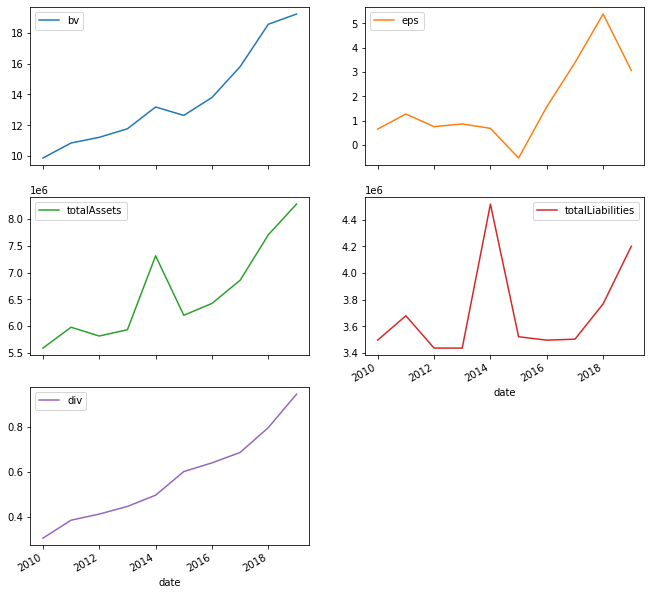

In [849]:
df_stl[['bv','eps','totalAssets','totalLiabilities','div']].plot(subplots = True, 
                                                                figsize = (11,11),
                                                                layout = (3,-1))

In [863]:
annual_growth(944345.0,35913.0,10)

0.386717192519477

In [859]:
cf_ests_stl = [df_stl.freeCashFlow.mean()]
grs = [0.1,0.15]
drs= [0.1,0.15,0.2]


In [861]:
intrn_avg(intrinsic_cash(cf_ests_stl,grs,drs,lgr,df_stl.shares.values[0],10))

defaultdict(float,
            {'548.2235,10.0%': 40.161478468242194,
             '548.2235,15.0%': 57.940112821173535})

In [864]:
annual_growth(19.225632,9.872028,10)

0.06892546815767853

In [862]:
df_stl.bv

date
2010     9.872028
2011    10.848585
2012    11.216236
2013    11.772901
2014    13.186448
2015    12.640222
2016    13.806698
2017    15.809311
2018    18.561656
2019    19.225632
Name: bv, dtype: float64

In [866]:
intrinsic_bk(0.6,13,0.05, 0.10,10)

11.850862366467041

# FINANCE
# BEN

In [901]:
dict_ben_cash,errs_ben = url_import(['BEN'], 'cash-flow-statement')
dict_ben_balance,errs_ben = url_import(['BEN'], 'balance-sheet-statement')
dict_ben_income,errs_ben = url_import(['BEN'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/BEN?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/BEN?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/BEN?apikey=cb3b0c371586d9ce915d359479fe1c81


In [902]:
df_ben_cash = pd.DataFrame(dict_ben_cash)
df_ben_bal = pd.DataFrame(dict_ben_balance)
df_ben_income = pd.DataFrame(dict_ben_income)

In [869]:
df_ben_bal.date = df_ben_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_ben_cash.date = df_ben_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_ben_income.date = df_ben_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [870]:
df_ben_bal.set_index(['date'], inplace = True)
df_ben_cash.set_index(['date'], inplace = True)
df_ben_income.set_index(['date'], inplace = True)

In [871]:
df_ben_cash.drop('netIncome',axis = 1, inplace = True)

In [872]:
df_ben_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [873]:
df_ben = pd.concat([df_ben_income,df_ben_bal,df_ben_cash],axis = 1)

In [874]:
df_ben.drop(['symbol','period'],axis = 1, inplace =True)

In [875]:
df_ben['shares'] = 495E06

In [876]:
df_ben.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [877]:
df_ben = df_ben/1000

In [878]:
df_ben[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_ben[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [879]:
df_ben = df_ben.sort_index()

In [880]:
df_ben_main = df_ben.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [881]:
df_ben_main['netIncome'] = df_ben_income['netIncome'] / 1000

# ANA

In [882]:
df_ben = metrics(df_ben)

In [884]:
df_ben.de.mean()

0.10000959487323356

In [885]:
df_ben.debtRatio

2005    1.505539
2006    0.692825
2007    0.154673
2008    0.124103
2009    0.061738
2010    0.087379
2011    0.075062
2012    0.106165
2013    0.077822
2014    0.073253
2015    0.082519
2016    0.087038
2017    0.059553
2018    0.048382
2019    0.047956
Name: debtRatio, dtype: float64

In [887]:
df_ben.curr.mean()

16.313429891617872

In [888]:
df_ben.intCov

2005           NaN
2006     55.897505
2007     89.041645
2008    133.202310
2009    318.905861
2010    118.664728
2011     71.049979
2012     68.534060
2013     62.287846
2014     67.957806
2015     76.454545
2016     47.408818
2017     43.966990
2018     43.503080
2019     63.052632
Name: intCov, dtype: float64

In [890]:
df_ben[['roe','rof','rocf']].mean()

roe     0.176019
rof     0.154372
rocf    0.162829
dtype: float64

In [893]:
df_ben[['totalAssets','totalLiabilities','operatingIncome','totalDebt']].apply(lambda x: 
                                                                               annual_growth(
                                                                               x[-2],x[2],14))

totalAssets         0.205716
totalLiabilities    0.040576
operatingIncome     0.001744
totalDebt           0.109667
dtype: float64

In [896]:
annual_growth(1,0.2,15)

0.11326357684480337

In [897]:
df_ben[['bv','div']].mean()

bv     18.548236
div     1.114008
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12aba23d0>,
      dtype=object)

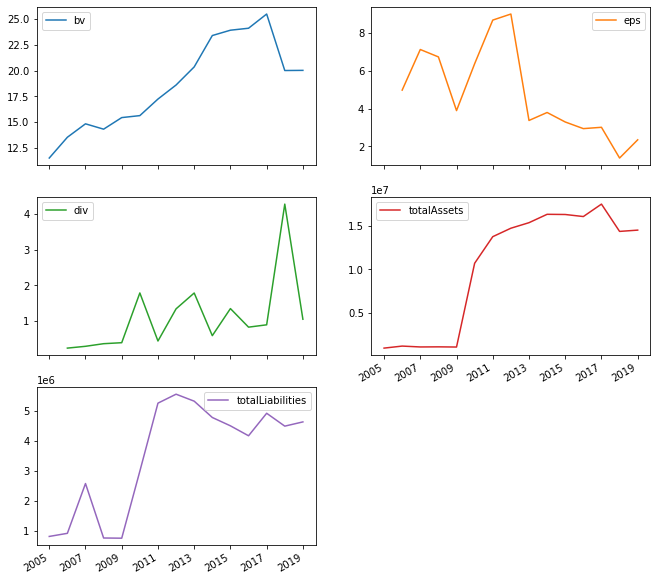

In [899]:
df_ben[['bv','eps','div','totalAssets','totalLiabilities']].plot(subplots = True,figsize = (11,11),
                                                                layout = (3,-1))

In [900]:
df_ben[['netCashUsedProvidedByFinancingActivities','netCashUsedForInvestingActivites']]

,netCashUsedProvidedByFinancingActivities,netCashUsedForInvestingActivites
2005,NaN,NaN
2006,-853438.0,36524.0
2007,-1449247.0,-306168.0
2008,-1299975.0,-1096122.0
2009,-340608.0,289939.0
2010,-594919.0,-32668.0
2011,-968185.0,435913.0
2012,-1084900.0,871500.0
2013,-2018100.0,254100.0
2014,-1195300.0,330200.0


# ivz


In [911]:
dict_ivz_cash,errs_ivz = url_import(['IVZ'], 'cash-flow-statement')
dict_ivz_balance,errs_ivz = url_import(['IVZ'], 'balance-sheet-statement')
dict_ivz_income,errs_ivz = url_import(['IVZ'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/IVZ?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/IVZ?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/IVZ?apikey=cb3b0c371586d9ce915d359479fe1c81


In [912]:
df_ivz_cash = pd.DataFrame(dict_ivz_cash)
df_ivz_bal = pd.DataFrame(dict_ivz_balance)
df_ivz_income = pd.DataFrame(dict_ivz_income)

In [913]:
df_ivz_bal.date = df_ivz_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_ivz_cash.date = df_ivz_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_ivz_income.date = df_ivz_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [914]:
df_ivz_bal.set_index(['date'], inplace = True)
df_ivz_cash.set_index(['date'], inplace = True)
df_ivz_income.set_index(['date'], inplace = True)

In [915]:
df_ivz_cash.drop('netIncome',axis = 1, inplace = True)

In [916]:
df_ivz_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [917]:
df_ivz = pd.concat([df_ivz_income,df_ivz_bal,df_ivz_cash],axis = 1)

In [918]:
df_ivz.drop(['symbol','period'],axis = 1, inplace =True)

In [919]:
df_ivz['shares'] = 458E06

In [920]:
df_ivz.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [921]:
df_ivz = df_ivz/1000

In [922]:
df_ivz[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_ivz[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [923]:
df_ivz = df_ivz.sort_index()

In [924]:
df_ivz_main = df_ivz.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [925]:
df_ivz_main['netIncome'] = df_ivz_income['netIncome'] / 1000

# ANA

In [927]:
df_ivz = metrics(df_ivz)

In [930]:
df_ivz.de.mean()

0.19294867064199173

In [929]:
df_ivz.debtRatio

date
2007    0.098723
2008    0.118799
2009    0.068292
2010    0.044302
2011    0.066403
2012    0.067801
2013    0.082437
2014    0.077669
2015    0.082670
2016    0.081696
2017    0.065547
2018    0.077757
2019    0.052772
Name: debtRatio, dtype: float64

In [932]:
df_ivz.curr.mean()

2.191592437470376

In [938]:
df_ivz.rocf.mean()

0.0972233568885848

In [941]:
annual_growth(1.2,0.3,12)

0.12246204830937302

In [942]:
df_ivz[['bv','div']].mean()

bv     17.994054
div     0.693601
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b1d4d90>,
      dtype=object)

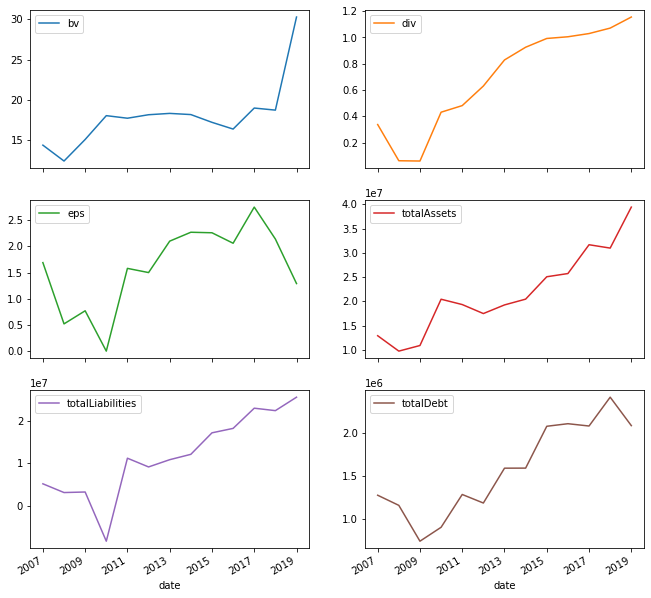

In [943]:
df_ivz[['bv','div','eps','totalAssets','totalLiabilities','totalDebt']].plot(subplots = True,
                                                                            figsize =(11,11)
                                                                            ,layout=(3,-1))

In [944]:
df_ivz=price_ratios(df_ivz,8)

In [946]:
df_ivz[['pe','ps','pb','pfcf']]

,pe,ps,pb,pfcf
date,,,,
2007,4.733728,0.944817,0.555994,4.177879
2008,15.384615,1.107953,0.644050,8.914842
2009,10.389610,1.394747,0.530093,10.149584
2010,inf,1.050549,0.443337,9.662447
2011,5.063291,0.895362,0.451282,4.271392
2012,5.333333,0.877185,0.440554,5.088889
2013,3.809524,0.788873,0.436575,5.294798
2014,3.524229,0.711857,0.440067,3.433283
2015,3.539823,0.715220,0.464662,3.944026


In [948]:
annual_growth(992300.0,361000,10)

0.1064035967908965

In [951]:
cf_ivz = [df_ivz.freeCashFlow.median()]
grs = [0.05,0.1]


In [952]:
intrinsic_cash(cf_ivz,grs,drs,lgr,df_ivz.shares.values[0],10)

defaultdict(list,
            {'726.3,5.0%': [26.375917731651153,
              14.950612625426288,
              10.392050094503613],
             '726.3,10.0%': [39.19210854647536,
              20.867427422131218,
              13.826050689494894]})

In [955]:
intrinsic_bk(0.7,18,0.07,0.15,10)

12.265633180777279

In [971]:
df_stl = metrics(df_stl)

In [972]:
df_stl[['ocfRatio','fcfRatio']]

,ocfRatio,fcfRatio
date,,
2010,0.026870,0.005700
2011,0.060813,0.039931
2012,0.061136,0.030475
2013,0.042341,0.016999
2014,0.070532,0.057765
2015,0.136743,0.121666
2016,0.109651,0.084171
2017,0.077537,0.060246
2018,0.119733,0.099484


# STOR


In [973]:
dict_sto_cash,errs_sto = url_import(['STOR'], 'cash-flow-statement')
dict_sto_balance,errs_sto = url_import(['STOR'], 'balance-sheet-statement')
dict_sto_income,errs_sto = url_import(['STOR'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/STOR?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/STOR?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/STOR?apikey=cb3b0c371586d9ce915d359479fe1c81


In [974]:
df_sto_cash = pd.DataFrame(dict_sto_cash)
df_sto_bal = pd.DataFrame(dict_sto_balance)
df_sto_income = pd.DataFrame(dict_sto_income)

In [975]:
df_sto_bal.date = df_sto_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_sto_cash.date = df_sto_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_sto_income.date = df_sto_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [976]:
df_sto_bal.set_index(['date'], inplace = True)
df_sto_cash.set_index(['date'], inplace = True)
df_sto_income.set_index(['date'], inplace = True)

In [977]:
df_sto_cash.drop('netIncome',axis = 1, inplace = True)

In [978]:
df_sto_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [979]:
df_sto = pd.concat([df_sto_income,df_sto_bal,df_sto_cash],axis = 1)

In [980]:
df_sto.drop(['symbol','period'],axis = 1, inplace =True)

In [981]:
df_sto['shares'] = 244E06

In [982]:
df_sto.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [983]:
df_sto = df_sto/1000

In [984]:
df_sto[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_sto[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [985]:
df_sto = df_sto.sort_index()

In [986]:
df_sto_main = df_sto.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [987]:
df_sto_main['netIncome'] = df_sto_income['netIncome'] / 1000

# ANAL

In [988]:
df_sto = metrics(df_sto)

In [993]:
df_sto.debtRatio.mean()

0.031137785120201766

In [994]:
df_sto.curr

date
2015    106.721047
2016     44.960814
2017     20.223062
2018     52.197541
2019           inf
Name: curr, dtype: float64

In [998]:
df_sto[['rof','rocf','fcfRatio','ocfRatio']]

,rof,rocf,fcfRatio,ocfRatio
date,,,,
2015,0.090250,0.090250,0.652815,0.652815
2016,0.099186,0.099186,0.654467,0.654467
2017,0.097581,0.097581,0.683288,0.683288
2018,0.101379,0.101379,0.724316,0.724316
2019,0.102184,0.102184,0.688485,0.688485


# SYF

In [1009]:
dict_syf_cash,errs_syf = url_import(['SYF'], 'cash-flow-statement')
dict_syf_balance,errs_syf = url_import(['SYF'], 'balance-sheet-statement')
dict_syf_income,errs_syf = url_import(['SYF'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/SYF?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/SYF?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/SYF?apikey=cb3b0c371586d9ce915d359479fe1c81


In [1010]:
df_syf_cash = pd.DataFrame(dict_syf_cash)
df_syf_bal = pd.DataFrame(dict_syf_balance)
df_syf_income = pd.DataFrame(dict_syf_income)

In [1011]:
df_syf_bal.date = df_syf_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_syf_cash.date = df_syf_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_syf_income.date = df_syf_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [1012]:
df_syf_bal.set_index(['date'], inplace = True)
df_syf_cash.set_index(['date'], inplace = True)
df_syf_income.set_index(['date'], inplace = True)

In [1013]:
df_syf_cash.drop('netIncome',axis = 1, inplace = True)

In [1014]:
df_syf_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [1015]:
df_syf = pd.concat([df_syf_income,df_syf_bal,df_syf_cash],axis = 1)

In [1016]:
df_syf.drop(['symbol','period'],axis = 1, inplace =True)

In [1017]:
df_syf['shares'] = 583E06

In [1018]:
df_syf.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [1019]:
df_syf = df_syf/1000

In [1020]:
df_syf[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_syf[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [1021]:
df_syf = df_syf.sort_index()

In [1022]:
df_syf_main = df_syf.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [1023]:
df_syf_main['netIncome'] = df_syf_income['netIncome'] / 1000

# ana

In [1024]:
df_syf = metrics(df_syf)

In [1025]:
df_syf.de

date
2014    0.062512
2015    0.000000
2016    1.419203
2017    1.461220
2018    1.634828
2019    1.316676
Name: de, dtype: float64

In [1026]:
df_syf.debtRatio

date
2014    0.008652
2015    0.000000
2016    0.223342
2017    0.217090
2018    0.224698
2019    0.189514
Name: debtRatio, dtype: float64

In [1029]:
df_syf.shortTermDebt

date
2014    0.0
2015    0.0
2016    0.0
2017    0.0
2018    0.0
2019    0.0
Name: shortTermDebt, dtype: float64

In [1030]:
df_syf.intCov

date
2014    3.672451
2015    3.111013
2016    2.860577
2017    2.389648
2018    1.948663
2019    2.133130
Name: intCov, dtype: float64

In [1031]:
df_syf[['roe','rof','rocf','fcfRatio']]

,roe,rof,rocf,fcfRatio
date,,,,
2014,0.201279,0.509639,0.509639,0.471731
2015,0.175659,0.490638,0.490638,0.511370
2016,0.158566,0.480628,0.480628,0.504287
2017,0.135942,0.626388,0.626388,0.593767
2018,0.190080,0.636463,0.636463,0.579600
2019,0.248343,0.595838,0.595838,0.535151


In [1033]:
df_syf[['totalAssets','ocf','totalLiabilities']].apply(lambda x: annual_growth(x[-1],x[0],5))

totalAssets         0.067251
ocf                 0.109797
totalLiabilities    0.065877
dtype: float64

In [1036]:
annual_growth(1,0.4,3)

0.35720880829745316

In [1037]:
df_syf[['bv','div']].median()

bv     24.382504
div     0.566038
dtype: float64

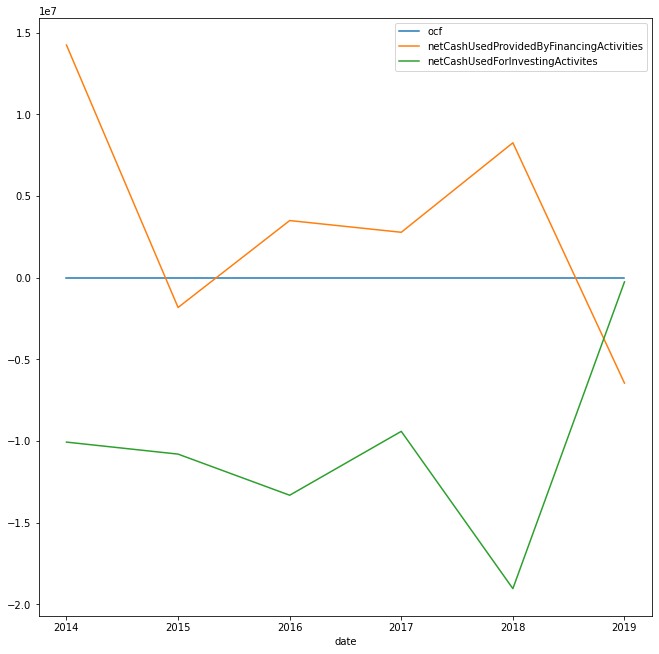

In [1038]:
df_syf[['ocf','netCashUsedProvidedByFinancingActivities','netCashUsedForInvestingActivites']] \
.plot(figsize = (11,11))

In [1039]:
df_syf = price_ratios(df_syf,18)

In [1040]:
df_syf[['pe','ps','pb']]

,pe,ps,pb
date,,,
2014,6.474820,0.927032,1.001527
2015,6.766917,0.867775,0.832593
2016,6.642066,0.775610,0.739222
2017,7.407407,0.698855,0.737249
2018,4.787234,0.651073,0.714948
2019,3.220036,0.624680,0.695520


In [1042]:
annual_growth(8990000.0,5340000.0,5)

0.10979735889291375

In [1046]:
cf_syf = [df_syf.freeCashFlow.median()]
grs = [0.06,0.1]


In [1050]:
intrinsic_cash(cf_syf, grs,drs,lgr,df_syf.shares.values[0],10)

defaultdict(list,
            {'7869.5,6.0%': [242.87634429894365,
              135.87823810635078,
              93.53619781946296],
             '7869.5,10.0%': [333.6004655721637,
              177.6220714193333,
              117.68636896813847]})

In [1051]:
intrinsic_bk(0.6,24,0.08,0.1,5)

24.170563264555952

# omf

In [1052]:
dict_omf_cash,errs_omf = url_import(['OMF'], 'cash-flow-statement')
dict_omf_balance,errs_omf = url_import(['OMF'], 'balance-sheet-statement')
dict_omf_income,errs_omf = url_import(['OMF'], 'income-statement')

https://fmpcloud.io/api/v3/cash-flow-statement/OMF?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/balance-sheet-statement/OMF?apikey=cb3b0c371586d9ce915d359479fe1c81
https://fmpcloud.io/api/v3/income-statement/OMF?apikey=cb3b0c371586d9ce915d359479fe1c81


In [1053]:
df_omf_cash = pd.DataFrame(dict_omf_cash)
df_omf_bal = pd.DataFrame(dict_omf_balance)
df_omf_income = pd.DataFrame(dict_omf_income)

In [1054]:
df_omf_bal.date = df_omf_bal.date.map(lambda x: re.sub(r'-.*$','',x))
df_omf_cash.date = df_omf_cash.date.map(lambda x: re.sub(r'-.*$','',x))
df_omf_income.date = df_omf_income.date.map(lambda x: re.sub(r'-.*$','',x))

In [1055]:
df_omf_bal.set_index(['date'], inplace = True)
df_omf_cash.set_index(['date'], inplace = True)
df_omf_income.set_index(['date'], inplace = True)

In [1056]:
df_omf_cash.drop('netIncome',axis = 1, inplace = True)

In [1057]:
df_omf_cash.rename({'inventory': 'inventoryCash'}, axis = 1, inplace = True)

In [1058]:
df_omf = pd.concat([df_omf_income,df_omf_bal,df_omf_cash],axis = 1)

In [1059]:
df_omf.drop(['symbol','period'],axis = 1, inplace =True)

In [1060]:
df_omf['shares'] = 134E06

In [1061]:
df_omf.drop(['fillingDate','finalLink','link'],axis = 1,inplace = True)

In [1062]:
df_omf = df_omf/1000

In [1063]:
df_omf[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] = df_omf[['grossProfitRatio',
 'ebitdaratio',
 'operatingIncomeRatio',
 'incomeBeforeTaxRatio',
 'netIncomeRatio','eps']] * 1000

In [1064]:
df_omf = df_omf.sort_index()

In [1065]:
df_omf_main = df_omf.loc[:,['netIncomeRatio','totalLiabilities','totalAssets','totalStockholdersEquity']]

In [1066]:
df_omf_main['netIncome'] = df_omf_income['netIncome'] / 1000

# ANA

In [1067]:
df_omf = metrics(df_omf)

In [1069]:
df_omf.de.mean()

4.584493939882641

In [1072]:
df_omf.debtRatio.mean()

0.7203122338590691

In [1073]:
df_omf.curr

date
2013    inf
2014    inf
2015    inf
2016    inf
2017    inf
2018    inf
2019    inf
Name: curr, dtype: float64

In [1074]:
df_omf.intCov

date
2013    0.287213
2014         inf
2015        -inf
2016         inf
2017         inf
2018         inf
2019         inf
Name: intCov, dtype: float64

In [1077]:
df_syf[['roe','rof','rocf','fcfRatio']].median()

roe         0.182869
rof         0.552738
rocf        0.552738
fcfRatio    0.523261
dtype: float64

In [1078]:
df_omf.recTurnOver

date
2013    inf
2014    inf
2015    inf
2016    inf
2017    inf
2018    inf
2019    inf
Name: recTurnOver, dtype: float64